# **💁🏻🗨️💁🏻‍♂️대화 요약 Baseline code**
> **Dialogue Summarization** 경진대회에 오신 여러분 환영합니다! 🎉    
> 본 대회에서는 최소 2명에서 최대 7명이 등장하여 나누는 대화를 요약하는 BART 기반 모델의 baseline code를 제공합니다.     
> 주어진 데이터를 활용하여 일상 대화에 대한 요약을 효과적으로 생성하는 모델을 만들어봅시다!

## ⚙️ 데이터 및 환경설정

### 1) 필요한 라이브러리 설치

- 필요한 라이브러리를 설치한 후 불러옵니다.

In [1]:
import pandas as pd
import os
import re
import json
import yaml
from glob import glob
from tqdm import tqdm
from pprint import pprint
import torch
import pytorch_lightning as pl
from rouge import Rouge # 모델의 성능을 평가하기 위한 라이브러리입니다.

from torch.utils.data import Dataset , DataLoader
from transformers import AutoTokenizer, BartForConditionalGeneration, BartConfig
from transformers import Seq2SeqTrainingArguments, Seq2SeqTrainer
from transformers import Trainer, TrainingArguments
from transformers import EarlyStoppingCallback

import wandb # 모델 학습 과정을 손쉽게 Tracking하고, 시각화할 수 있는 라이브러리입니다.

### 2) Config file 만들기 (선택)
- 모델 생성에 필요한 다양한 매개변수 정보를 저장할 수 있습니다.  
  따라서, 코드 상에서 모델의 매개변수를 설정할 수도 있지만 독립적인 매개변수 정보 파일을 생성하여 관리할 수 있습니다.

In [2]:
# config 설정에 tokenizer 모듈이 사용되므로 미리 tokenizer를 정의해줍니다.
tokenizer = AutoTokenizer.from_pretrained("digit82/kobart-summarization")

In [3]:
config_data = {
    "general": {
        "data_path": "/home/data", # 모델 생성에 필요한 데이터 경로를 사용자 환경에 맞게 지정합니다.
        "model_name": "digit82/kobart-summarization", # 불러올 모델의 이름을 사용자 환경에 맞게 지정할 수 있습니다.
        "output_dir": "./" # 모델의 최종 출력 값을 저장할 경로를 설정합니다.
    },
    "tokenizer": {
        "encoder_max_len": 612,
        "decoder_max_len": 100,
        "bos_token": f"{tokenizer.bos_token}",
        "eos_token": f"{tokenizer.eos_token}",
        # 특정 단어들이 분해되어 tokenization이 수행되지 않도록 special_tokens을 지정해줍니다.
        "special_tokens": ['#Person1#', '#Person2#', '#Person3#', '#PhoneNumber#', '#Address#', '#PassportNumber#']
    },
    "training": {
        "overwrite_output_dir": True,
        "num_train_epochs": 20,
        "learning_rate": 1e-5,
        "per_device_train_batch_size": 50,
        "per_device_eval_batch_size": 32,
        "warmup_ratio": 0.1,
        "weight_decay": 0.01,
        "lr_scheduler_type": 'cosine',
        "optim": 'adamw_torch',
        "gradient_accumulation_steps": 1,
        "eval_strategy": 'epoch',
        "save_strategy": 'epoch',
        "save_total_limit": 5,
        "fp16": True,
        "load_best_model_at_end": True,
        "seed": 42,
        "logging_dir": "./logs",
        "logging_strategy": "epoch",
        "predict_with_generate": True,
        "max_length": 100,
        "min_length": 0, # 최소 생성 길이 추가 (원하는 길이로 설정)
        "do_train": True,
        "do_eval": True,
        "early_stopping_patience": 3,
        "early_stopping_threshold": 0.001,
        "report_to": "wandb" # (선택) wandb를 사용할 때 설정합니다.
    },
    # (선택) wandb 홈페이지에 가입하여 얻은 정보를 기반으로 작성합니다.
    "wandb": {
        #"entity": "wandb_repo",
        "project": "leejy_summarization",
        "name": "kobart_finetuning_1"
    },
    "inference": {
        "ckt_path": "model ckt path", # 사전 학습이 진행된 모델의 checkpoint를 저장할 경로를 설정합니다.
        "result_path": "./prediction/",
        "no_repeat_ngram_size": 2,
        "early_stopping": True,
        "max_length": 100,
        "min_length": 10, # 최소 생성 길이 추가 (원하는 길이로 설정)
        "num_beams": 4,
        "batch_size" : 32,
        # 정확한 모델 평가를 위해 제거할 불필요한 생성 토큰들을 정의합니다.
        "remove_tokens": ['<usr>', f"{tokenizer.bos_token}", f"{tokenizer.eos_token}", f"{tokenizer.pad_token}"]
    }
}

- 참고✅    
: wandb 라이브러리를 사용하기 위해선 entity, project, name를 지정해주어야 합니다. wandb 홈페이지에 가입한 후 얻은 정보를 입력하여 작동할 수 있습니다.

In [4]:
# 모델의 구성 정보를 YAML 파일로 저장합니다.
config_path = "./config.yaml"
with open(config_path, "w") as file:
    yaml.dump(config_data, file, allow_unicode=True)

### 3) Configuration 불러오기

In [5]:
# 저장된 config 파일을 불러옵니다.
config_path = "./config.yaml"

with open(config_path, "r") as file:
    loaded_config = yaml.safe_load(file)

# 불러온 config 파일의 전체 내용을 확인합니다.
pprint(loaded_config)

{'general': {'data_path': '/home/data',
             'model_name': 'digit82/kobart-summarization',
             'output_dir': './'},
 'inference': {'batch_size': 32,
               'ckt_path': 'model ckt path',
               'early_stopping': True,
               'max_length': 100,
               'min_length': 10,
               'no_repeat_ngram_size': 2,
               'num_beams': 4,
               'remove_tokens': ['<usr>', '<s>', '</s>', '<pad>'],
               'result_path': './prediction/'},
 'tokenizer': {'bos_token': '<s>',
               'decoder_max_len': 100,
               'encoder_max_len': 612,
               'eos_token': '</s>',
               'special_tokens': ['#Person1#',
                                  '#Person2#',
                                  '#Person3#',
                                  '#PhoneNumber#',
                                  '#Address#',
                                  '#PassportNumber#']},
 'training': {'do_eval': True,
              'do_tr

In [6]:
# 실험에 쓰일 데이터의 경로, 사용될 모델, 모델의 최종 출력 결과를 저장할 경로에 대해 확인합니다.
loaded_config['general']

{'data_path': '/home/data',
 'model_name': 'digit82/kobart-summarization',
 'output_dir': './'}

In [7]:
# 이곳에 사용자가 저장한 데이터 dir 설정하기
# loaded_config['general']['data_path'] = "data_path"

In [8]:
# 데이터 전처리를 하기 위해 tokenization 과정에서 필요한 정보들을 확인합니다.
loaded_config['tokenizer']

{'bos_token': '<s>',
 'decoder_max_len': 100,
 'encoder_max_len': 612,
 'eos_token': '</s>',
 'special_tokens': ['#Person1#',
  '#Person2#',
  '#Person3#',
  '#PhoneNumber#',
  '#Address#',
  '#PassportNumber#']}

In [9]:
# 모델이 훈련 시 적용될 매개변수를 확인합니다.
loaded_config['training']

{'do_eval': True,
 'do_train': True,
 'early_stopping_patience': 3,
 'early_stopping_threshold': 0.001,
 'eval_strategy': 'epoch',
 'fp16': True,
 'gradient_accumulation_steps': 1,
 'learning_rate': 1e-05,
 'load_best_model_at_end': True,
 'logging_dir': './logs',
 'logging_strategy': 'epoch',
 'lr_scheduler_type': 'cosine',
 'max_length': 100,
 'min_length': 0,
 'num_train_epochs': 20,
 'optim': 'adamw_torch',
 'overwrite_output_dir': True,
 'per_device_eval_batch_size': 32,
 'per_device_train_batch_size': 50,
 'predict_with_generate': True,
 'report_to': 'wandb',
 'save_strategy': 'epoch',
 'save_total_limit': 5,
 'seed': 42,
 'warmup_ratio': 0.1,
 'weight_decay': 0.01}

In [10]:
# 모델 학습 과정에 대한 정보를 제공해주는 wandb 설정 내용을 확인합니다.
loaded_config['wandb']

{'name': 'kobart_finetuning_1', 'project': 'leejy_summarization'}

In [11]:
# (선택) 이곳에 사용자가 사용할 wandb config 설정
#loaded_config['wandb']['entity'] = "사용할 wandb repo name"
loaded_config['wandb']['name'] = "kobart_finetuning_1"
loaded_config['wandb']['project'] = "leejy_summarization"

In [12]:
# 모델이 최종 결과를 출력하기 위한 매개변수 정보를 확인합니다.
loaded_config['inference']

{'batch_size': 32,
 'ckt_path': 'model ckt path',
 'early_stopping': True,
 'max_length': 100,
 'min_length': 10,
 'no_repeat_ngram_size': 2,
 'num_beams': 4,
 'remove_tokens': ['<usr>', '<s>', '</s>', '<pad>'],
 'result_path': './prediction/'}

### 4) 데이터 불러와서 확인해보기
- 실험에서 쓰일 데이터를 load하여 데이터의 구조와 내용을 살펴보겠습니다.
- Train, dev, test 순서대로 12457, 499, 250개 씩 데이터가 구성되어 있습니다.

In [13]:
# config에 저장된 데이터 경로를 통해 train과 validation data를 불러옵니다.
data_path = loaded_config['general']['data_path']

# train data의 구조와 내용을 확인합니다.
train_df = pd.read_csv(os.path.join(data_path,'train.csv'))
train_df.tail()

,fname,dialogue,summary,topic
12452,train_12455,#Person1#: 안녕하세요. 혹시 맨체스터에서 오신 Mr. Green 맞으신가요...,Tan Ling은 흰머리와 수염이 특징인 Mr. Green을 맞이하여 호텔로 안내합...,호텔 안내
12453,train_12456,"#Person1#: Mister Ewing이 우리 회의장에 4시에 오라고 했지, 맞...",#Person1#과 #Person2#는 Mister Ewing의 요청에 따라 회의장...,회의 준비
12454,train_12457,#Person1#: 오늘 어떻게 도와드릴까요?\n#Person2#: 차를 빌리고 싶...,#Person2#는 #Person1#의 도움으로 5일 동안 소형차를 대여합니다.,차량 대여
12455,train_12458,#Person1#: 너 오늘 좀 기분 안 좋아 보인다? 무슨 일 있어?\n#Pers...,#Person2#의 어머니가 직장을 잃으셨다. #Person2#는 어머니가 우울해하...,실직과 대처
12456,train_12459,"#Person1#: 엄마, 나 다음 주 토요일에 이모부네 가족 보러 가는데, 오늘 ...",#Person1#은 다음 주 토요일에 이모부네 가족을 방문하기 위해 짐을 싸야 하는...,가족 방문 준비


In [14]:
# validation data의 구조와 내용을 확인합니다.
val_df = pd.read_csv(os.path.join(data_path,'dev.csv'))
val_df.tail()

,fname,dialogue,summary,topic
494,dev_495,#Person1#: 새해가 되니까 나도 새 출발을 하기로 했어.\n#Person2#...,#Person1#은 새해에 담배를 끊고 커밍아웃 하기로 결심했습니다. #Person...,새해 결심
495,dev_496,#Person1#: 너 Joe랑 결혼했지?\n#Person2#: Joe? 무슨 말이...,"#Person1#은 #Person2#가 Joe와 결혼했다고 생각하지만, #Perso...",사랑과 결혼 오해
496,dev_497,"#Person1#: 어떻게 도와드릴까요, 아줌마?\n#Person2#: 제 차에서 ...","#Person2#의 차에서 소리가 나며, 브레이크 수리가 필요한 상황입니다. #Pe...",차량 소음 및 수리
497,dev_498,"#Person1#: 여보세요, 아마존 고객 서비스입니다. 어떻게 도와드릴까요?\n#...",#Person2#가 아마존 고객 서비스에 전화하여 아마존에서 구매한 책에 53페이지...,책 페이지 누락
498,dev_499,#Person1#: 벌써 여름이 다가오다니 믿기지 않아. \n#Person2#: 맞...,"#Person2#는 여름방학 동안 파티에서 일하는 회사에서 일하며, 주로 음식 준비...",여름방학 일자리


## 1. 데이터 가공 및 데이터셋 클래스 구축
- csv file 을 불러와서 encoder 와 decoder의 입력형태로 가공해줍니다.
- 가공된 데이터를 torch dataset class 로 구축하여 모델에 입력가능한 형태로 만듭니다.

In [15]:
korean_stopwords = [
    '이', '있', '하', '것', '들', '그', '되', '수', '이', '보', '않', '없', '나', '사람', '주', '아니', '등', '같', '우리', '때', '년', '가', '한', '지', '대하', '오', '말', '일', '그렇', '위하'
    ]

In [16]:
# 검색 성능을 위해 set으로 변환해주는 것이 좋습니다.
korean_stopwords_set = set(korean_stopwords)

In [17]:
def remove_stopwords(text, stopwords):
    if not isinstance(text, str):
        return text
    words = text.split()
    # 불용어 목록에 없는 단어들만 다시 조합
    words = [word for word in words if word not in stopwords]
    return ' '.join(words)

In [18]:
# 데이터 전처리를 위한 클래스로, 데이터셋을 데이터프레임으로 변환하고 인코더와 디코더의 입력을 생성합니다.
class Preprocess:
    def __init__(self,
            bos_token: str,
            eos_token: str,
        ) -> None:

        self.bos_token = bos_token
        self.eos_token = eos_token

    @staticmethod
    # 실험에 필요한 컬럼을 가져옵니다.
    def make_set_as_df(file_path, is_train = True):
        if is_train:
            df = pd.read_csv(file_path)
            train_df = df[['fname','dialogue','summary']]
            return train_df
        else:
            df = pd.read_csv(file_path)
            test_df = df[['fname','dialogue']]
            return test_df

    def make_input(self, dataset, is_test=False):
    # <<-- 불용어 제거 로직 적용 시작 -->>
    # 원본 dialogue에 불용어 제거 함수를 적용합니다.
    # 주의: topic과 결합하기 전에 수행해야 합니다.
        processed_dialogue = dataset['dialogue'].apply(lambda x: remove_stopwords(x, korean_stopwords_set))
        # <<-- 불용어 제거 로직 적용 끝 -->>

        # 'topic' 컬럼이 있는 학습/검증 데이터셋의 경우
        if 'topic' in dataset.columns:
            # 주제와 "불용어가 제거된" 대화 내용을 결합하여 인코더 입력으로 사용
            # [수정] dataset['dialogue'] -> processed_dialogue
            encoder_input = dataset.apply(lambda row: f"주제: {row['topic']} | 대화: {processed_dialogue[row.name]}", axis=1)
        else: # topic 컬럼이 없는 테스트 데이터셋의 경우
            # [수정] dataset['dialogue'] -> processed_dialogue
            encoder_input = processed_dialogue

        if is_test:
            decoder_input = [self.bos_token] * len(dataset['dialogue'])
            return encoder_input.tolist(), list(decoder_input)
        else:
            decoder_input = dataset['summary'].apply(lambda x : self.bos_token + str(x))
            decoder_output = dataset['summary'].apply(lambda x : str(x) + self.eos_token)
            return encoder_input.tolist(), decoder_input.tolist(), decoder_output.tolist()


In [19]:
# Train에 사용되는 Dataset 클래스를 정의합니다.
class DatasetForTrain(Dataset):
    def __init__(self, encoder_input, decoder_input, labels, len):
        self.encoder_input = encoder_input
        self.decoder_input = decoder_input
        self.labels = labels
        self.len = len

    def __getitem__(self, idx):
        item = {key: val[idx].clone().detach() for key, val in self.encoder_input.items()} # item[input_ids], item[attention_mask]
        item2 = {key: val[idx].clone().detach() for key, val in self.decoder_input.items()} # item2[input_ids], item2[attention_mask]
        item2['decoder_input_ids'] = item2['input_ids']
        item2['decoder_attention_mask'] = item2['attention_mask']
        item2.pop('input_ids')
        item2.pop('attention_mask')
        item.update(item2) #item[input_ids], item[attention_mask] item[decoder_input_ids], item[decoder_attention_mask]
        item['labels'] = self.labels['input_ids'][idx] #item[input_ids], item[attention_mask] item[decoder_input_ids], item[decoder_attention_mask], item[labels]
        return item

    def __len__(self):
        return self.len

# Validation에 사용되는 Dataset 클래스를 정의합니다.
class DatasetForVal(Dataset):
    def __init__(self, encoder_input, decoder_input, labels, len):
        self.encoder_input = encoder_input
        self.decoder_input = decoder_input
        self.labels = labels
        self.len = len

    def __getitem__(self, idx):
        item = {key: val[idx].clone().detach() for key, val in self.encoder_input.items()} # item[input_ids], item[attention_mask]
        item2 = {key: val[idx].clone().detach() for key, val in self.decoder_input.items()} # item2[input_ids], item2[attention_mask]
        item2['decoder_input_ids'] = item2['input_ids']
        item2['decoder_attention_mask'] = item2['attention_mask']
        item2.pop('input_ids')
        item2.pop('attention_mask')
        item.update(item2) #item[input_ids], item[attention_mask] item[decoder_input_ids], item[decoder_attention_mask]
        item['labels'] = self.labels['input_ids'][idx] #item[input_ids], item[attention_mask] item[decoder_input_ids], item[decoder_attention_mask], item[labels]
        return item

    def __len__(self):
        return self.len

# Test에 사용되는 Dataset 클래스를 정의합니다.
class DatasetForInference(Dataset):
    def __init__(self, encoder_input, test_id, len):
        self.encoder_input = encoder_input
        self.test_id = test_id
        self.len = len

    def __getitem__(self, idx):
        item = {key: val[idx].clone().detach() for key, val in self.encoder_input.items()}
        item['ID'] = self.test_id[idx]
        return item

    def __len__(self):
        return self.len


In [20]:
# tokenization 과정까지 진행된 최종적으로 모델에 입력될 데이터를 출력합니다.
def prepare_train_dataset(config, preprocessor, data_path, tokenizer):
    train_file_path = os.path.join(data_path,'train.csv')
    val_file_path = os.path.join(data_path,'dev.csv')

    # train, validation에 대해 각각 데이터프레임을 구축합니다.
    train_data = preprocessor.make_set_as_df(train_file_path)
    val_data = preprocessor.make_set_as_df(val_file_path)

    print('-'*150)
    print(f'train_data:\n {train_data["dialogue"][0]}')
    print(f'train_label:\n {train_data["summary"][0]}')

    print('-'*150)
    print(f'val_data:\n {val_data["dialogue"][0]}')
    print(f'val_label:\n {val_data["summary"][0]}')

    encoder_input_train , decoder_input_train, decoder_output_train = preprocessor.make_input(train_data)
    encoder_input_val , decoder_input_val, decoder_output_val = preprocessor.make_input(val_data)
    print('-'*10, 'Load data complete', '-'*10,)

    tokenized_encoder_inputs = tokenizer(encoder_input_train, return_tensors="pt", padding=True,
                            add_special_tokens=True, truncation=True, max_length=config['tokenizer']['encoder_max_len'], return_token_type_ids=False)
    tokenized_decoder_inputs = tokenizer(decoder_input_train, return_tensors="pt", padding=True,
                        add_special_tokens=True, truncation=True, max_length=config['tokenizer']['decoder_max_len'], return_token_type_ids=False)
    tokenized_decoder_ouputs = tokenizer(decoder_output_train, return_tensors="pt", padding=True,
                        add_special_tokens=True, truncation=True, max_length=config['tokenizer']['decoder_max_len'], return_token_type_ids=False)

    train_inputs_dataset = DatasetForTrain(tokenized_encoder_inputs, tokenized_decoder_inputs, tokenized_decoder_ouputs,len(encoder_input_train))

    val_tokenized_encoder_inputs = tokenizer(encoder_input_val, return_tensors="pt", padding=True,
                        add_special_tokens=True, truncation=True, max_length=config['tokenizer']['encoder_max_len'], return_token_type_ids=False)
    val_tokenized_decoder_inputs = tokenizer(decoder_input_val, return_tensors="pt", padding=True,
                        add_special_tokens=True, truncation=True, max_length=config['tokenizer']['decoder_max_len'], return_token_type_ids=False)
    val_tokenized_decoder_ouputs = tokenizer(decoder_output_val, return_tensors="pt", padding=True,
                        add_special_tokens=True, truncation=True, max_length=config['tokenizer']['decoder_max_len'], return_token_type_ids=False)

    val_inputs_dataset = DatasetForVal(val_tokenized_encoder_inputs, val_tokenized_decoder_inputs, val_tokenized_decoder_ouputs,len(encoder_input_val))

    print('-'*10, 'Make dataset complete', '-'*10,)
    return train_inputs_dataset, val_inputs_dataset

## 2. 데이터 분석하기
- 데이터를 다양한 기법을 이용하여 분석합니다.

In [21]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import re

# Matplotlib 한글 폰트 설정 (환경에 맞게 폰트 경로를 지정해야 할 수 있습니다)
# Colab, Kaggle 등에서는 아래 코드로 나눔 폰트를 설치할 수 있습니다.
# !sudo apt-get install -y fonts-nanum
# !sudo fc-cache -fv
# !rm ~/.cache/matplotlib -rf
# plt.rc('font', family='NanumBarunGothic')

# 분석 시각화 스타일 설정
sns.set_style("whitegrid")

# 데이터 로드 (이전에 사용하신 config를 활용)
data_path = loaded_config['general']['data_path']
train_df = pd.read_csv(f"{data_path}/train.csv")
val_df = pd.read_csv(f"{data_path}/dev.csv")

print("데이터 로드 완료!")
train_df.head()

데이터 로드 완료!


,fname,dialogue,summary,topic
0,train_0,"#Person1#: 안녕하세요, Mr. Smith. 저는 Dr. Hawkins입니다...","Mr. Smith는 Dr. Hawkins에게 건강검진을 받으러 와서, 매년 검진 필...",건강검진
1,train_1,"#Person1#: 안녕하세요, Mrs. Parker. 잘 지내셨나요?\n#Pers...","Mrs. Parker가 Ricky와 함께 백신 접종을 위해 방문하였고, Dr. Pe...",백신 접종
2,train_2,"#Person1#: 저기요, 열쇠 세트 본 적 있어요?\n#Person2#: 어떤 ...",#Person1#은 열쇠 세트를 잃어버리고 #Person2#에게 찾는 것을 도와달라...,열쇠 분실
3,train_3,#Person1#: 너 여자친구 있는 거 왜 말 안 했어?\n#Person2#: 미...,#Person1#은 #Person2#가 여자친구가 있고 결혼할 예정이라는 사실을 말...,여자친구와의 결혼
4,train_4,"#Person1#: 안녕, 오늘 너무 멋져 보이네요. 저랑 춤 한 곡 추실래요?\n...","Malik은 Wen과 Nikki에게 춤을 제안하고, Wen은 발을 밟는 것을 감수하...",춤 제안


각 컬럼별 단어 수 통계:
       dialogue_word_count  summary_word_count
count         12457.000000        12457.000000
mean             84.464478           16.480694
std              43.613074            7.015613
min              17.000000            4.000000
25%              56.000000           11.000000
50%              75.000000           15.000000
75%             106.000000           20.000000
max             508.000000           75.000000


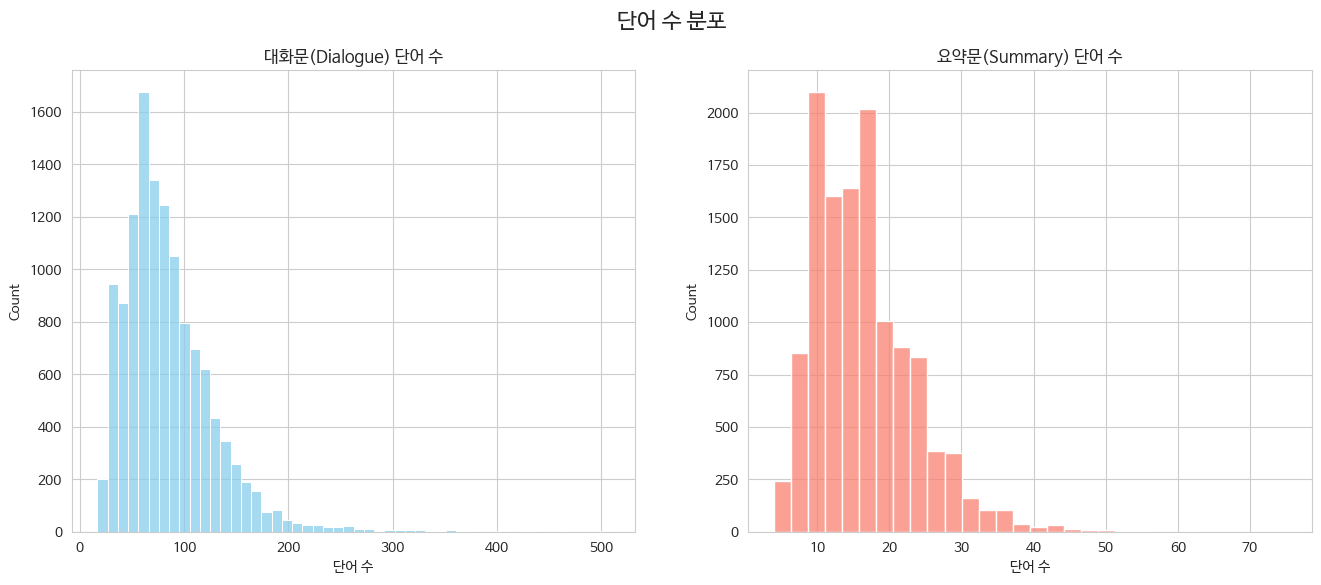

In [22]:
plt.rc('font', family='NanumBarunGothic')

# 'dialogue'와 'summary'의 단어 수를 계산하여 새로운 컬럼 추가
train_df['dialogue_word_count'] = train_df['dialogue'].apply(lambda x: len(str(x).split()))
train_df['summary_word_count'] = train_df['summary'].apply(lambda x: len(str(x).split()))

# 길이 통계 정보 출력
print("각 컬럼별 단어 수 통계:")
print(train_df[['dialogue_word_count', 'summary_word_count']].describe())

# 길이 분포 시각화
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
fig.suptitle('단어 수 분포', fontsize=16)

# 대화문 길이 분포
sns.histplot(train_df['dialogue_word_count'], bins=50, ax=axes[0], color='skyblue')
axes[0].set_title('대화문(Dialogue) 단어 수')
axes[0].set_xlabel('단어 수')

# 요약문 길이 분포
sns.histplot(train_df['summary_word_count'], bins=30, ax=axes[1], color='salmon')
axes[1].set_title('요약문(Summary) 단어 수')
axes[1].set_xlabel('단어 수')

plt.show()

대화 참여자 수 분포:
speaker_count
2    12335
3      107
4       10
5        3
6        1
7        1
Name: count, dtype: int64


/tmp/ipykernel_695537/1801966576.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='speaker_count', data=train_df, palette='viridis')


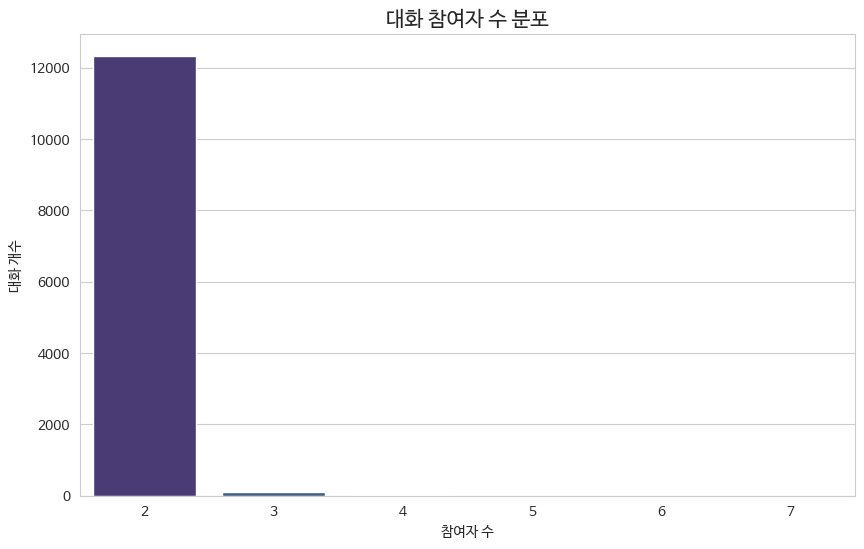

In [23]:
# 정규표현식을 사용해 #PersonN# 패턴을 찾아 참여자 수를 계산하는 함수
def count_speakers(text):
    speakers = re.findall(r'(#Person\d#)', str(text))
    if not speakers:
        return 0
    return len(set(speakers))

# 참여자 수 계산하여 'speaker_count' 컬럼 추가
train_df['speaker_count'] = train_df['dialogue'].apply(count_speakers)

print("대화 참여자 수 분포:")
print(train_df['speaker_count'].value_counts().sort_index())

# 참여자 수 분포 시각화
plt.figure(figsize=(10, 6))
sns.countplot(x='speaker_count', data=train_df, palette='viridis')
plt.title('대화 참여자 수 분포', fontsize=15)
plt.xlabel('참여자 수')
plt.ylabel('대화 개수')
plt.show()

상위 15개 주제:
topic
음식 주문       130
취업 면접       109
길 안내         66
호텔 체크인       40
아파트 임대       30
일상 대화        29
쇼핑           27
주말 계획        26
면접           25
호텔 예약        25
여행 계획        23
항공권 예약       22
영화 감상        21
작별 인사        21
휴가 계획        21
가격 협상        20
택시 이용        20
영화 관람 계획     18
의료 상담        16
파티 초대        16
Name: count, dtype: int64


/tmp/ipykernel_695537/839871912.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=top_topics.index, x=top_topics.values, orient='h', palette='coolwarm')


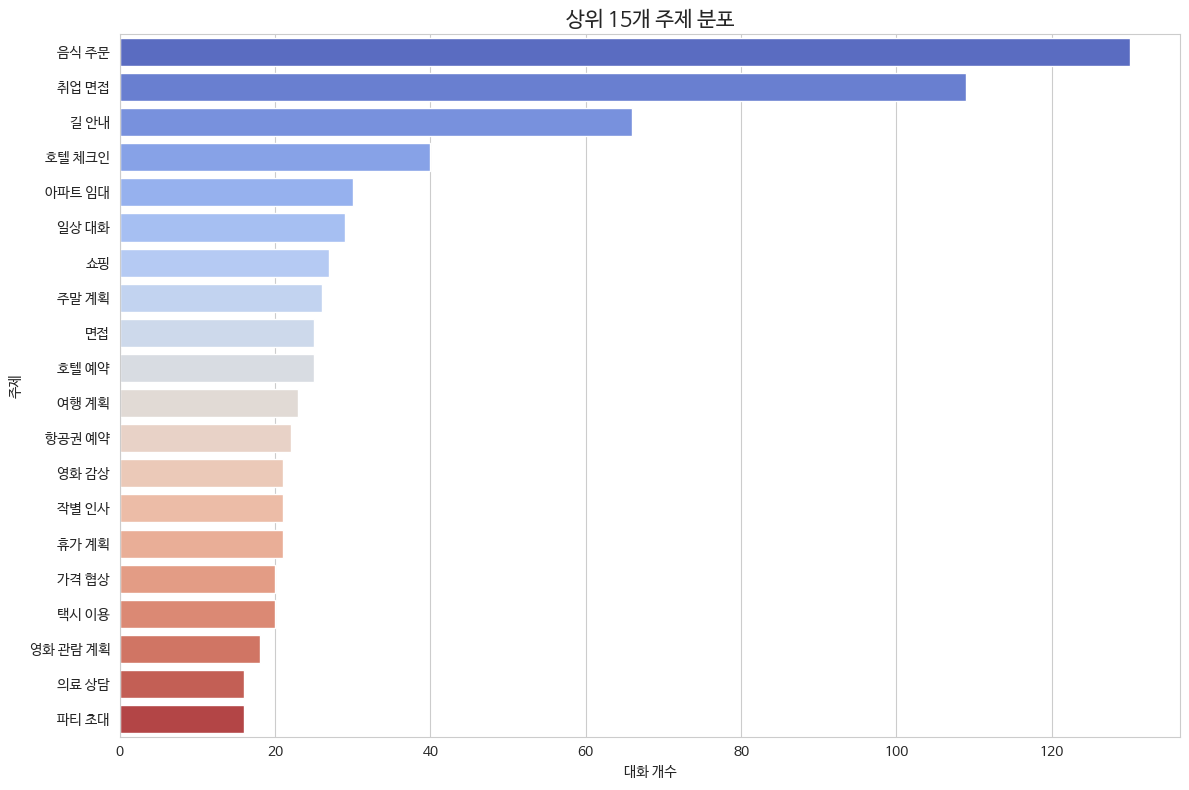

In [24]:
# 주제별 데이터 개수 확인 (상위 15개)
top_topics = train_df['topic'].value_counts().nlargest(20)

print("상위 15개 주제:")
print(top_topics)

# 주제 분포 시각화
plt.figure(figsize=(12, 8))
sns.barplot(y=top_topics.index, x=top_topics.values, orient='h', palette='coolwarm')
plt.title('상위 15개 주제 분포', fontsize=15)
plt.xlabel('대화 개수')
plt.ylabel('주제')
plt.tight_layout()
plt.show()

In [25]:
# Calculate unique topics from train_df and print the total count.
unique_topics = train_df['topic'].unique()
print("총 주제 개수:", len(unique_topics))

# 전체 대화 개수 출력 (Train과 Validation)
print(f"전체 대화 개수 (Train): {len(train_df)}")
print(f"전체 대화 개수 (Validation): {len(val_df)}\n")

# 각 주제별 대화 개수 출력 (상위 주제 순)
print("각 주제별 대화 개수:")
print(top_topics)

총 주제 개수: 9235
전체 대화 개수 (Train): 12457
전체 대화 개수 (Validation): 499

각 주제별 대화 개수:
topic
음식 주문       130
취업 면접       109
길 안내         66
호텔 체크인       40
아파트 임대       30
일상 대화        29
쇼핑           27
주말 계획        26
면접           25
호텔 예약        25
여행 계획        23
항공권 예약       22
영화 감상        21
작별 인사        21
휴가 계획        21
가격 협상        20
택시 이용        20
영화 관람 계획     18
의료 상담        16
파티 초대        16
Name: count, dtype: int64


In [26]:
from sklearn.feature_extraction.text import CountVectorizer
import pandas as pd

# 바이그램(2-gram) 상위 20개 추출 함수
def get_top_ngrams(corpus, ngram_range=(2, 2), n=20):
    vec = CountVectorizer(ngram_range=ngram_range, stop_words=None).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

# 대화문과 요약문에서 자주 사용되는 바이그램 확인
top_dialogue_ngrams = get_top_ngrams(train_df['dialogue'].dropna())
top_summary_ngrams = get_top_ngrams(train_df['summary'].dropna())

print("--- 대화문 상위 바이그램 ---")
print(pd.DataFrame(top_dialogue_ngrams, columns=['Ngram', 'Count']))
print("\n--- 요약문 상위 바이그램 ---")
print(pd.DataFrame(top_summary_ngrams, columns=['Ngram', 'Count']))

--- 대화문 상위 바이그램 ---
             Ngram  Count
0       있어 person2   2166
1       거야 person2   1759
2       있어 person1   1663
3       거야 person1   1509
4    person1 안녕하세요   1418
5       person1 그럼   1416
6       person2 정말   1317
7       person2 맞아   1309
8       person1 정말   1305
9      있나요 person2   1246
10     있어요 person1   1227
11     있어요 person2   1046
12      person1 맞아    993
13      person2 그럼    973
14  도와드릴까요 person2    948
15   person1 알겠습니다    915
16      같아 person1    907
17      같아 person2    873
18     있나요 person1    812
19      person1 안녕    783

--- 요약문 상위 바이그램 ---
              Ngram  Count
0   person1 person2   3672
1        person1 에게   2258
2        person2 에게   2066
3   person2 person1   1957
4         대해 이야기합니다    264
5          대해 설명합니다    178
6          대해 이야기한다    161
7      있습니다 person1    153
8          대해 이야기하고    127
9       합니다 person1    127
10      있으며 person1    121
11     있습니다 person2    119
12      합니다 person2    118
13    설명합니다 person1    116
14      

--- 요약문 추상성 분석 ---
count    12457.000000
mean         0.930650
std          0.087472
min          0.333333
25%          0.888889
50%          0.952381
75%          1.000000
max          1.000000
Name: abstractiveness_score, dtype: float64


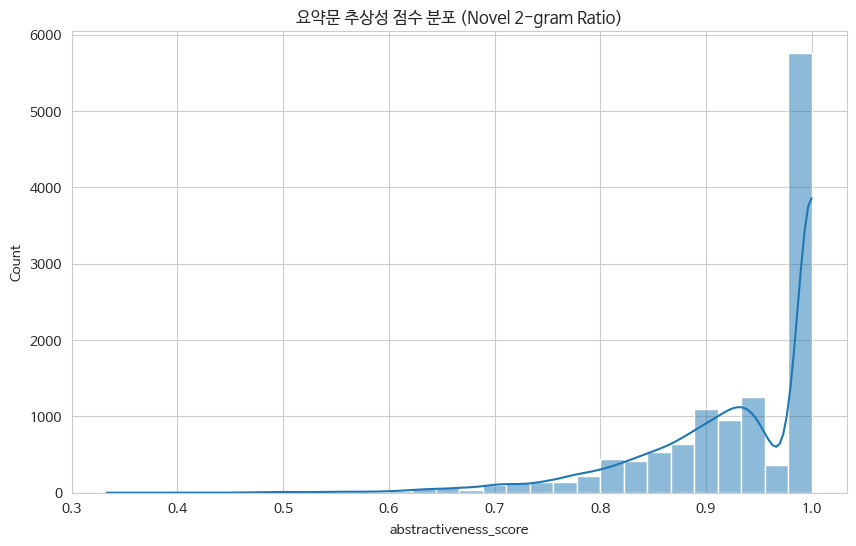

In [27]:
# 텍스트를 n-gram 집합으로 변환하는 함수
def get_ngrams(text, n):
    words = str(text).split()
    return set(zip(*[words[i:] for i in range(n)]))

# 새로운 바이그램(2-gram)의 비율 계산
def calculate_novel_ngram_ratio(row, n=2):
    dialogue_ngrams = get_ngrams(row['dialogue'], n)
    summary_ngrams = get_ngrams(row['summary'], n)
    
    if not summary_ngrams:
        return 0.0
        
    novel_ngrams = summary_ngrams - dialogue_ngrams
    return len(novel_ngrams) / len(summary_ngrams)

# 추상성 점수 계산
train_df['abstractiveness_score'] = train_df.apply(lambda row: calculate_novel_ngram_ratio(row, n=2), axis=1)

print("--- 요약문 추상성 분석 ---")
print(train_df['abstractiveness_score'].describe())

plt.figure(figsize=(10, 6))
sns.histplot(train_df['abstractiveness_score'], bins=30, kde=True)
plt.title('요약문 추상성 점수 분포 (Novel 2-gram Ratio)')
plt.show()

--- 주제별 대화문 단어 수 통계 ---
          count        mean        std   min    25%    50%     75%    max
topic                                                                    
가격 협상      20.0   91.400000  37.666682  27.0  65.50   97.5  117.75  154.0
길 안내       66.0   76.818182  30.558347  27.0  57.25   76.0  102.50  153.0
면접         25.0  131.320000  96.080574  50.0  64.00  100.0  142.00  459.0
쇼핑         27.0   75.370370  33.579009  30.0  49.50   71.0   90.50  170.0
아파트 임대     30.0   94.233333  70.950047  26.0  58.00   79.5  104.75  424.0
여행 계획      23.0   85.130435  37.145053  27.0  59.50   85.0  120.00  140.0
영화 감상      21.0   82.761905  33.528950  28.0  64.00   79.0  112.00  138.0
영화 관람 계획   18.0   80.611111  33.800694  42.0  55.75   71.0  101.00  159.0
음식 주문     130.0   59.353846  24.017714  21.0  41.00   56.0   71.75  156.0
의료 상담      16.0   76.750000  22.625944  19.0  63.50   78.0   90.50  109.0
일상 대화      29.0   67.896552  35.536043  17.0  45.00   57.0   83.00  152.0
작별 인사      21.

/tmp/ipykernel_695537/2097338126.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='topic', y='dialogue_word_count', data=df_top10, palette='Set3')


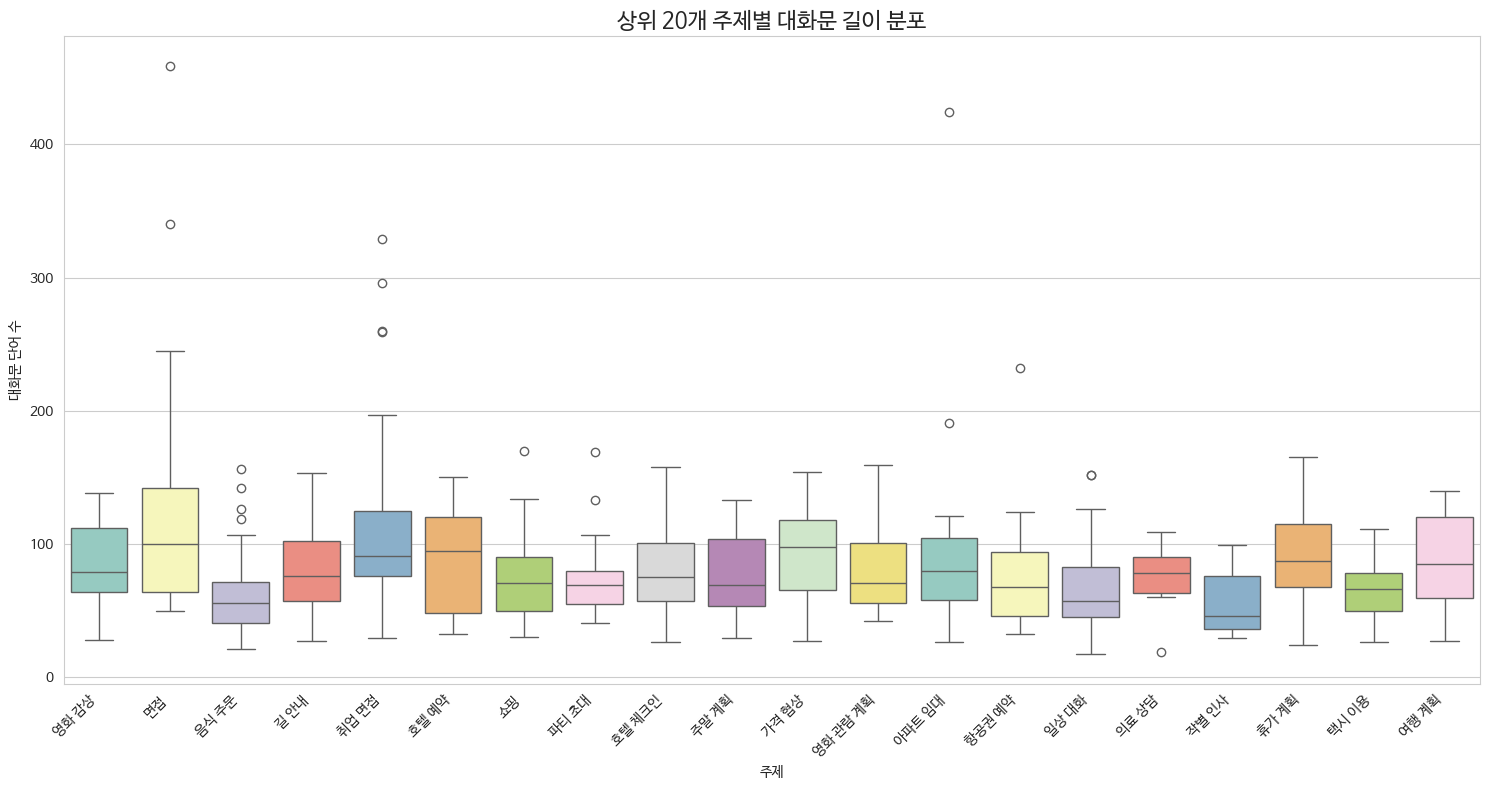

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns

# 가장 빈도가 높은 상위 10개 주제를 선택합니다.
top_20_topics = train_df['topic'].value_counts().nlargest(20).index
df_top10 = train_df[train_df['topic'].isin(top_20_topics)]

print("--- 주제별 대화문 단어 수 통계 ---")
print(df_top10.groupby('topic')['dialogue_word_count'].describe())

# 주제별 대화 길이 분포를 Boxplot으로 시각화
plt.figure(figsize=(15, 8))
sns.boxplot(x='topic', y='dialogue_word_count', data=df_top10, palette='Set3')
plt.title('상위 20개 주제별 대화문 길이 분포', fontsize=16)
plt.xlabel('주제')
plt.ylabel('대화문 단어 수')
plt.xticks(rotation=45, ha='right') # x축 라벨 회전
plt.tight_layout()
plt.show()

--- 대화 구조 분석 통계 ---
        total_turns  balance_ratio
count  12457.000000   12457.000000
mean       9.485189       0.523385
std        4.145723       0.035587
min        2.000000       0.272727
25%        7.000000       0.500000
50%        9.000000       0.500000
75%       12.000000       0.545455
max       59.000000       0.666667


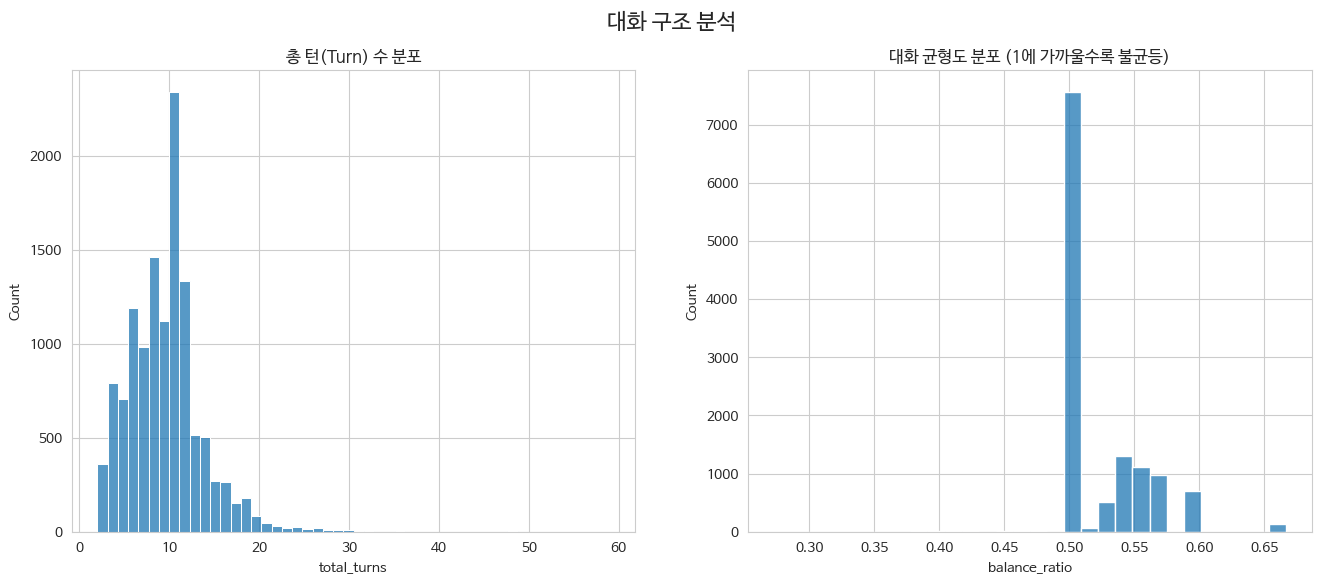

In [29]:
import re
import numpy as np

def analyze_dialogue_structure(dialogue):
    # Person 태그를 기준으로 발화(turn)를 분리합니다.
    turns = re.split(r'(#Person\d#:\s*)', str(dialogue))
    if len(turns) <= 1:
        return 0, 0.0

    # 화자별 발화 횟수 계산
    speakers = [t for t in turns if t.startswith('#Person')]
    speaker_counts = pd.Series(speakers).value_counts()
    
    # 전체 턴 수
    total_turns = len(speakers)
    
    # 대화 균형도 (1에 가까울수록 균등하게 대화)
    # (가장 많이 말한 사람의 발화 비중)
    if total_turns > 0:
        balance_ratio = speaker_counts.max() / total_turns
    else:
        balance_ratio = 0.0
        
    return total_turns, balance_ratio

# 분석 적용
results = train_df['dialogue'].apply(analyze_dialogue_structure)
train_df['total_turns'] = results.apply(lambda x: x[0])
train_df['balance_ratio'] = results.apply(lambda x: x[1])

print("--- 대화 구조 분석 통계 ---")
print(train_df[['total_turns', 'balance_ratio']].describe())

# 시각화
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
fig.suptitle('대화 구조 분석', fontsize=16)

sns.histplot(train_df['total_turns'], bins=50, ax=axes[0])
axes[0].set_title('총 턴(Turn) 수 분포')

sns.histplot(train_df['balance_ratio'], bins=30, ax=axes[1])
axes[1].set_title('대화 균형도 분포 (1에 가까울수록 불균등)')

plt.show()

--- Train 데이터 통계 ---
       dialogue_word_count  summary_word_count  abstractiveness_score
count         12457.000000        12457.000000           12457.000000
mean             84.464478           16.480694               0.930650
std              43.613074            7.015613               0.087472
min              17.000000            4.000000               0.333333
25%              56.000000           11.000000               0.888889
50%              75.000000           15.000000               0.952381
75%             106.000000           20.000000               1.000000
max             508.000000           75.000000               1.000000

--- Validation 데이터 통계 ---
       dialogue_word_count  summary_word_count  abstractiveness_score
count           499.000000          499.000000             499.000000
mean             83.541082           15.348697               0.940915
std              41.547667            6.720365               0.081052
min              22.000000            5.00

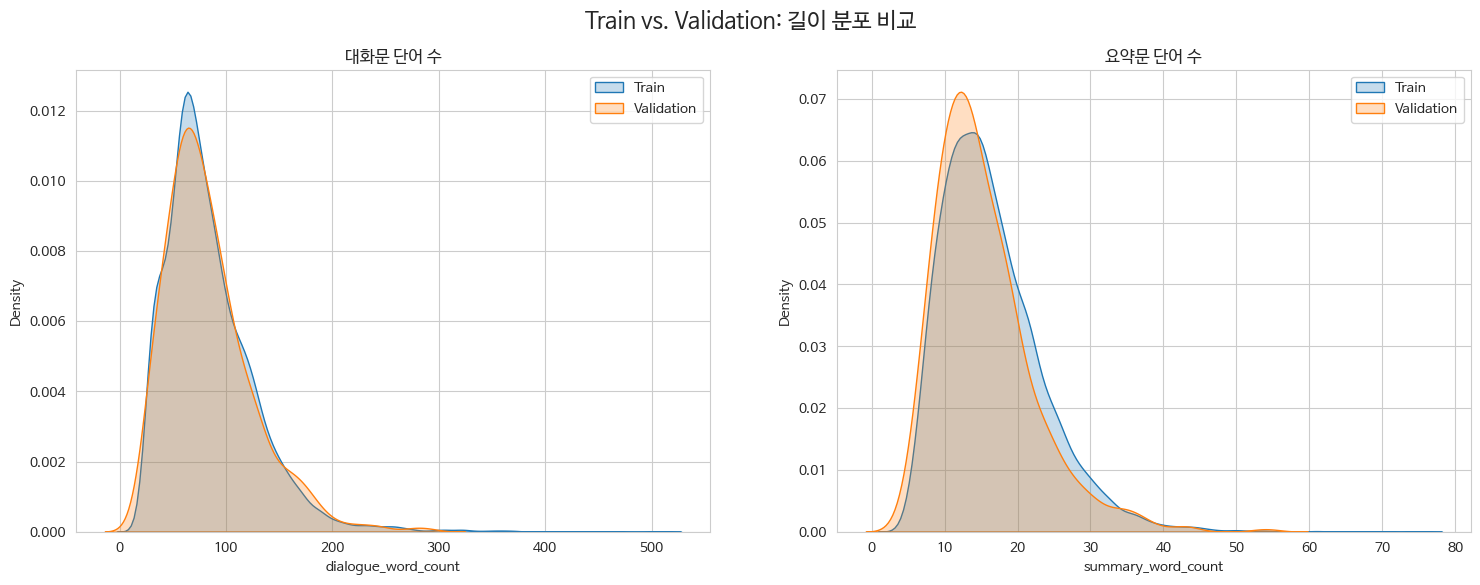

/tmp/ipykernel_695537/3714656308.py:63: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=train_topics.index, x=train_topics.values, ax=axes[0], palette='Blues_d')
/tmp/ipykernel_695537/3714656308.py:67: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=val_topics.index, x=val_topics.values, ax=axes[1], palette='Greens_d')


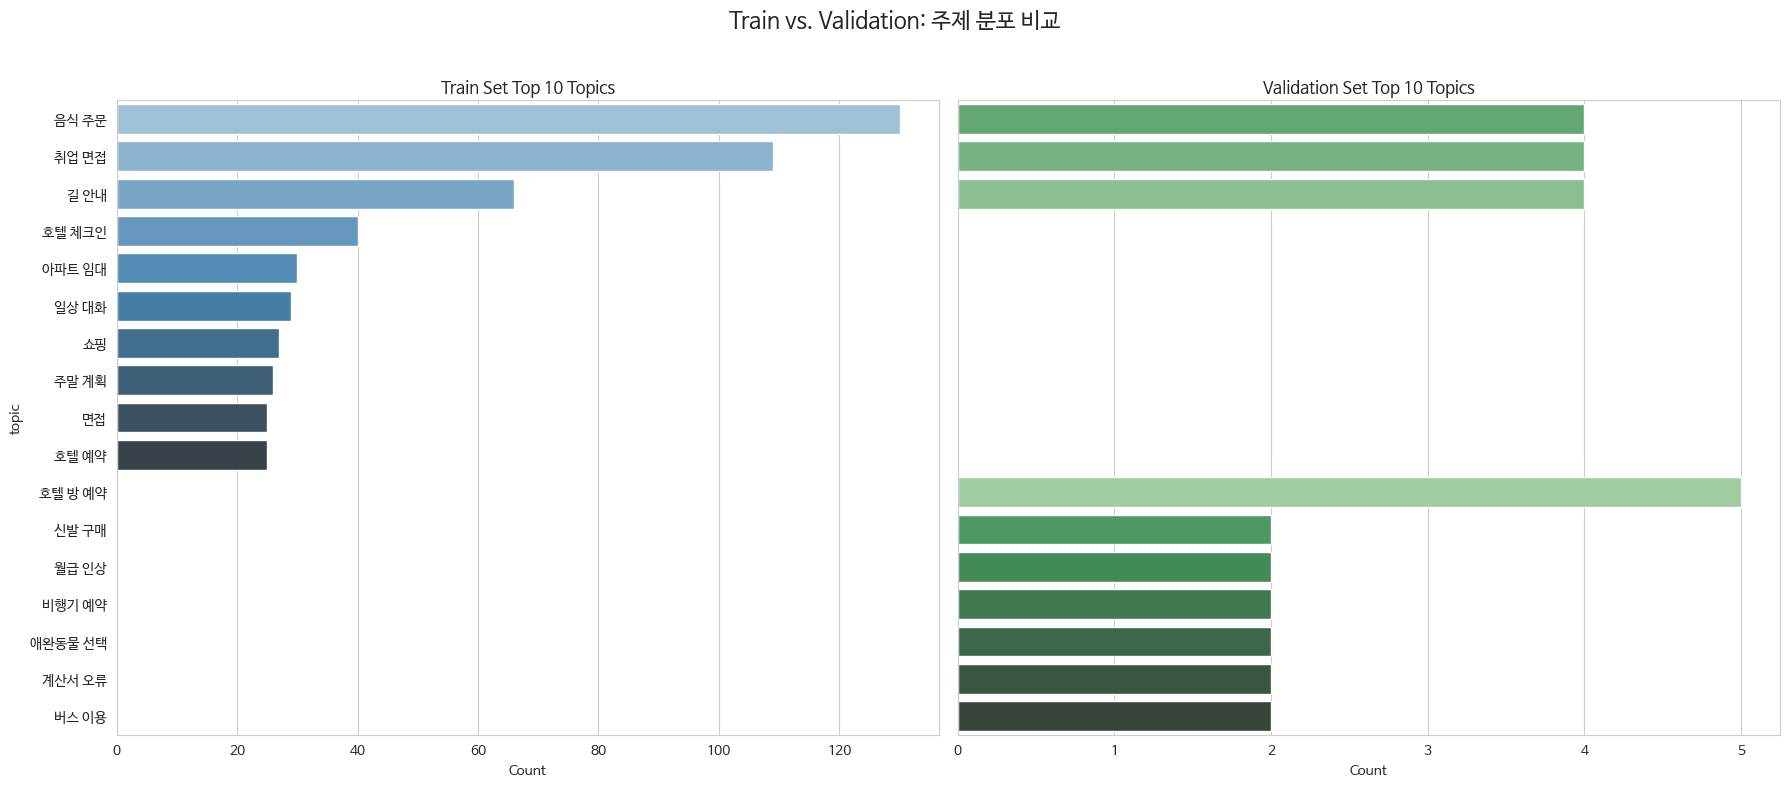

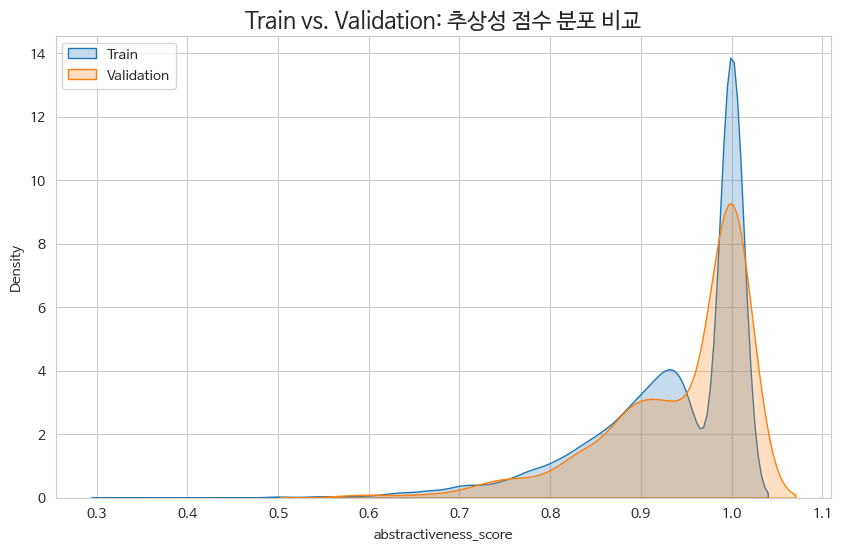

In [30]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# --- 데이터 로드 ---
# 이전에 사용하신 config 변수가 있다고 가정합니다.
# data_path = loaded_config['general']['data_path']
# train_df = pd.read_csv(f"{data_path}/train.csv")
# val_df = pd.read_csv(f"{data_path}/dev.csv")

# --- 비교를 위한 전처리 ---
# (이전에 사용한 함수들이 정의되어 있어야 합니다)
def get_ngrams(text, n):
    words = str(text).split()
    return set(zip(*[words[i:] for i in range(n)]))

def calculate_novel_ngram_ratio(row, n=2):
    dialogue_ngrams = get_ngrams(row['dialogue'], n)
    summary_ngrams = get_ngrams(row['summary'], n)
    if not summary_ngrams: return 0.0
    novel_ngrams = summary_ngrams - dialogue_ngrams
    return len(novel_ngrams) / len(summary_ngrams)

# 1. 각 데이터셋에 분석 컬럼 추가
for df in [train_df, val_df]:
    df['dialogue_word_count'] = df['dialogue'].apply(lambda x: len(str(x).split()))
    df['summary_word_count'] = df['summary'].apply(lambda x: len(str(x).split()))
    df['abstractiveness_score'] = df.apply(lambda row: calculate_novel_ngram_ratio(row, n=2), axis=1)

print("--- Train 데이터 통계 ---")
print(train_df[['dialogue_word_count', 'summary_word_count', 'abstractiveness_score']].describe())
print("\n--- Validation 데이터 통계 ---")
print(val_df[['dialogue_word_count', 'summary_word_count', 'abstractiveness_score']].describe())


# --- 2. 시각화를 통한 분포 비교 ---

# (1) 길이 분포 비교 (대화문 & 요약문)
fig, axes = plt.subplots(1, 2, figsize=(18, 6))
fig.suptitle('Train vs. Validation: 길이 분포 비교', fontsize=16)

sns.kdeplot(data=train_df, x='dialogue_word_count', ax=axes[0], label='Train', fill=True)
sns.kdeplot(data=val_df, x='dialogue_word_count', ax=axes[0], label='Validation', fill=True)
axes[0].set_title('대화문 단어 수')
axes[0].legend()

sns.kdeplot(data=train_df, x='summary_word_count', ax=axes[1], label='Train', fill=True)
sns.kdeplot(data=val_df, x='summary_word_count', ax=axes[1], label='Validation', fill=True)
axes[1].set_title('요약문 단어 수')
axes[1].legend()

plt.show()


# (2) 주제 분포 비교
fig, axes = plt.subplots(1, 2, figsize=(18, 8), sharey=True)
fig.suptitle('Train vs. Validation: 주제 분포 비교', fontsize=16)

train_topics = train_df['topic'].value_counts().nlargest(10)
val_topics = val_df['topic'].value_counts().nlargest(10)

sns.barplot(y=train_topics.index, x=train_topics.values, ax=axes[0], palette='Blues_d')
axes[0].set_title('Train Set Top 10 Topics')
axes[0].set_xlabel('Count')

sns.barplot(y=val_topics.index, x=val_topics.values, ax=axes[1], palette='Greens_d')
axes[1].set_title('Validation Set Top 10 Topics')
axes[1].set_xlabel('Count')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


# (3) 추상성 점수 분포 비교
plt.figure(figsize=(10, 6))
sns.kdeplot(data=train_df, x='abstractiveness_score', label='Train', fill=True)
sns.kdeplot(data=val_df, x='abstractiveness_score', label='Validation', fill=True)
plt.title('Train vs. Validation: 추상성 점수 분포 비교', fontsize=16)
plt.legend()
plt.show()

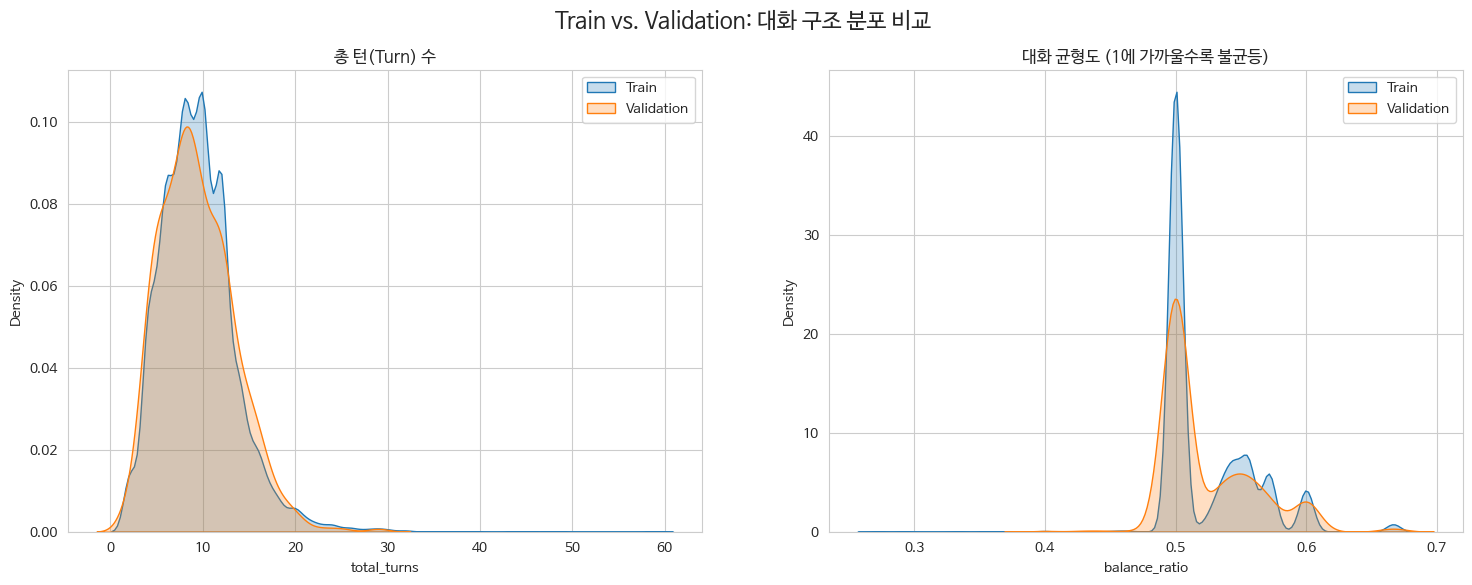

In [31]:
# (이전에 사용한 analyze_dialogue_structure 함수가 정의되어 있다고 가정합니다)
# def analyze_dialogue_structure(dialogue): ...

# 각 데이터셋에 대화 구조 분석 적용
for df in [train_df, val_df]:
    results = df['dialogue'].apply(analyze_dialogue_structure)
    df['total_turns'] = results.apply(lambda x: x[0])
    df['balance_ratio'] = results.apply(lambda x: x[1])

# 시각화를 통한 분포 비교
fig, axes = plt.subplots(1, 2, figsize=(18, 6))
fig.suptitle('Train vs. Validation: 대화 구조 분포 비교', fontsize=16)

# 총 턴(Turn) 수 분포 비교
sns.kdeplot(data=train_df, x='total_turns', ax=axes[0], label='Train', fill=True)
sns.kdeplot(data=val_df, x='total_turns', ax=axes[0], label='Validation', fill=True)
axes[0].set_title('총 턴(Turn) 수')
axes[0].legend()

# 대화 균형도 분포 비교
sns.kdeplot(data=train_df, x='balance_ratio', ax=axes[1], label='Train', fill=True)
sns.kdeplot(data=val_df, x='balance_ratio', ax=axes[1], label='Validation', fill=True)
axes[1].set_title('대화 균형도 (1에 가까울수록 불균등)')
axes[1].legend()

plt.show()

--- 단어 수 vs. 토큰 수 통계 비교 (Train Set) ---
       dialogue_word_count  dialogue_token_count  summary_word_count  \
count         12457.000000          12457.000000        12457.000000   
mean             84.464478            199.561532           16.480694   
std              43.613074             93.123736            7.015613   
min              17.000000             42.000000            4.000000   
25%              56.000000            141.000000           11.000000   
50%              75.000000            183.000000           15.000000   
75%             106.000000            245.000000           20.000000   
max             508.000000           1079.000000           75.000000   

       summary_token_count  
count         12457.000000  
mean             39.971984  
std              15.149897  
min               6.000000  
25%              29.000000  
50%              37.000000  
75%              48.000000  
max             161.000000  


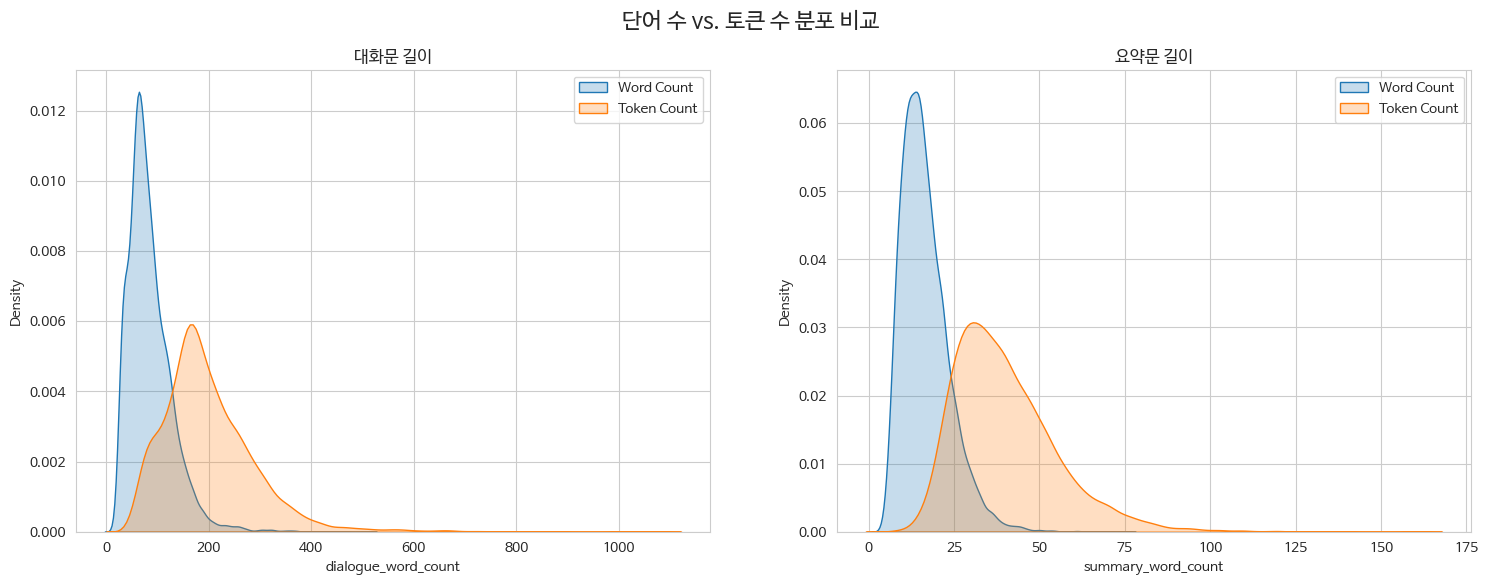

In [32]:
from transformers import AutoTokenizer

# baseline.ipynb에서 사용하는 토크나이저를 불러옵니다.
tokenizer = AutoTokenizer.from_pretrained("digit82/kobart-summarization")

# 토큰 개수를 계산하는 함수
def count_tokens(text):
    return len(tokenizer.encode(str(text)))

# Train 데이터셋에 토큰 수 컬럼 추가
train_df['dialogue_token_count'] = train_df['dialogue'].apply(count_tokens)
train_df['summary_token_count'] = train_df['summary'].apply(count_tokens)

print("--- 단어 수 vs. 토큰 수 통계 비교 (Train Set) ---")
print(train_df[['dialogue_word_count', 'dialogue_token_count', 'summary_word_count', 'summary_token_count']].describe())


# 시각화를 통해 단어 수와 토큰 수 분포 비교
fig, axes = plt.subplots(1, 2, figsize=(18, 6))
fig.suptitle('단어 수 vs. 토큰 수 분포 비교', fontsize=16)

sns.kdeplot(data=train_df, x='dialogue_word_count', ax=axes[0], label='Word Count', fill=True)
sns.kdeplot(data=train_df, x='dialogue_token_count', ax=axes[0], label='Token Count', fill=True)
axes[0].set_title('대화문 길이')
axes[0].legend()

sns.kdeplot(data=train_df, x='summary_word_count', ax=axes[1], label='Word Count', fill=True)
sns.kdeplot(data=train_df, x='summary_token_count', ax=axes[1], label='Token Count', fill=True)
axes[1].set_title('요약문 길이')
axes[1].legend()

plt.show()

In [33]:
# 1. 각 데이터셋의 전체 어휘 집합(Vocabulary Set) 생성
train_vocab = set(word for dialogue in train_df['dialogue'].dropna() for word in str(dialogue).split())
val_vocab = set(word for dialogue in val_df['dialogue'].dropna() for word in str(dialogue).split())

print(f"Train Set 고유 단어 수: {len(train_vocab):,} 개")
print(f"Validation Set 고유 단어 수: {len(val_vocab):,} 개")

# 2. 어휘 유사도 및 OOV 비율 계산
intersection_size = len(train_vocab.intersection(val_vocab))
union_size = len(train_vocab.union(val_vocab))
jaccard_similarity = intersection_size / union_size

oov_words = val_vocab - train_vocab
oov_rate = len(oov_words) / len(val_vocab)

# 3. 결과 출력
print("\n--- Train vs. Validation 어휘 비교 ---")
print(f"어휘 유사도 (Jaccard Similarity): {jaccard_similarity:.4f}")
print(f"Validation Set의 미등장 단어(OOV) 비율: {oov_rate:.2%}")
print(f"(Validation Set 단어 중 {oov_rate:.2%}는 Train Set에 등장하지 않은 새로운 단어입니다.)")

Train Set 고유 단어 수: 120,675 개
Validation Set 고유 단어 수: 13,695 개

--- Train vs. Validation 어휘 비교 ---
어휘 유사도 (Jaccard Similarity): 0.0874
Validation Set의 미등장 단어(OOV) 비율: 21.14%
(Validation Set 단어 중 21.14%는 Train Set에 등장하지 않은 새로운 단어입니다.)


In [34]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import re

def compare_datasets(train_df, val_df, test_df):
    """
    Train, Validation, Test 세 개의 데이터프레임을 입력받아 
    주요 특성을 비교하고 시각화하는 함수입니다.
    """
    print(" 데이터셋 비교 분석을 시작합니다... ".center(50, "="))
    
    # --- 데이터 전처리 ---
    train_copy = train_df.copy()
    val_copy = val_df.copy()
    test_copy = test_df.copy()

    def analyze_dialogue_structure(dialogue):
        turns = re.split(r'(#Person\d#:\s*)', str(dialogue))
        if len(turns) <= 1: return 0, 0.0
        speakers = [t for t in turns if t.startswith('#Person')]
        speaker_counts = pd.Series(speakers).value_counts()
        total_turns = len(speakers)
        balance_ratio = speaker_counts.max() / total_turns if total_turns > 0 else 0.0
        return total_turns, balance_ratio

    for df in [train_copy, val_copy, test_copy]:
        df['dialogue_word_count'] = df['dialogue'].apply(lambda x: len(str(x).split()))
        results = df['dialogue'].apply(analyze_dialogue_structure)
        df['total_turns'] = results.apply(lambda x: x[0])
        df['balance_ratio'] = results.apply(lambda x: x[1])
        
    train_copy['source'] = 'Train'
    val_copy['source'] = 'Validation'
    test_copy['source'] = 'Test'
    combined_df = pd.concat([train_copy, val_copy, test_copy], ignore_index=True)

    # --- 1. 대화문 길이 분포 비교 ---
    plt.figure(figsize=(12, 7))
    sns.kdeplot(data=combined_df, x='dialogue_word_count', hue='source', fill=True, palette='viridis')
    plt.title('대화문 길이 분포 비교', fontsize=16)
    plt.show()

    # --- 2. 주제 분포 비교 ---
    # 💡 [수정] test_df에는 'topic' 컬럼이 없으므로 train과 validation만 비교하도록 변경
    print("\n'test.csv'에는 'topic' 컬럼이 없으므로 Train과 Validation만 비교합니다.")
    fig, axes = plt.subplots(1, 2, figsize=(18, 8), sharey=True) # 1x3 -> 1x2로 변경
    fig.suptitle('주제 분포 비교 (Train vs. Validation)', fontsize=16)
    
    sns.countplot(y='topic', data=train_copy, ax=axes[0], order=train_copy.topic.value_counts().iloc[:10].index, palette='Blues_d')
    axes[0].set_title('Train Set Top 10 Topics')
    
    sns.countplot(y='topic', data=val_copy, ax=axes[1], order=val_copy.topic.value_counts().iloc[:10].index, palette='Greens_d')
    axes[1].set_title('Validation Set Top 10 Topics')
    
    # test_df 관련 plot 코드 삭제
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

    # --- 3. 대화 구조 분포 비교 ---
    fig, axes = plt.subplots(1, 2, figsize=(18, 6))
    fig.suptitle('대화 구조 분포 비교', fontsize=16)
    sns.kdeplot(data=combined_df, x='total_turns', hue='source', fill=True, ax=axes[0])
    axes[0].set_title('총 턴(Turn) 수')
    sns.kdeplot(data=combined_df, x='balance_ratio', hue='source', fill=True, ax=axes[1])
    axes[1].set_title('대화 균형도')
    plt.show()
    
    # --- 4. 어휘 비교 분석 ---
    train_vocab = set(word for dialogue in train_copy['dialogue'].dropna() for word in str(dialogue).split())
    val_vocab = set(word for dialogue in val_copy['dialogue'].dropna() for word in str(dialogue).split())
    test_vocab = set(word for dialogue in test_copy['dialogue'].dropna() for word in str(dialogue).split())

    val_oov_words = val_vocab - train_vocab
    val_oov_rate = len(val_oov_words) / len(val_vocab) if len(val_vocab) > 0 else 0
    test_oov_words = test_vocab - train_vocab
    test_oov_rate = len(test_oov_words) / len(test_vocab) if len(test_vocab) > 0 else 0

    print(" 어휘 비교 분석 ".center(50, "="))
    print(f"Train Set 고유 단어 수: {len(train_vocab):,} 개")
    print(f"Validation Set 고유 단어 수: {len(val_vocab):,} 개")
    print(f"Test Set 고유 단어 수: {len(test_vocab):,} 개")
    print("-" * 50)
    print(f"Train 대비 Validation Set OOV 비율: {val_oov_rate:.2%}")
    print(f"Train 대비 Test Set OOV 비율: {test_oov_rate:.2%}")
    print("=" * 50)

============== 데이터셋 비교 분석을 시작합니다... ==============


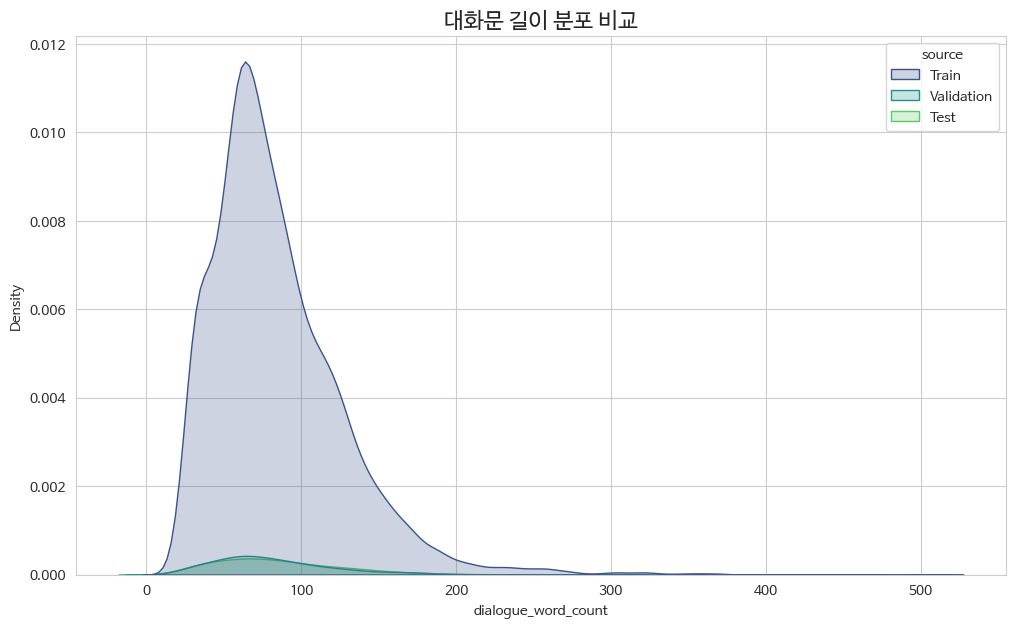


'test.csv'에는 'topic' 컬럼이 없으므로 Train과 Validation만 비교합니다.


/tmp/ipykernel_695537/1930742572.py:51: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y='topic', data=train_copy, ax=axes[0], order=train_copy.topic.value_counts().iloc[:10].index, palette='Blues_d')
/tmp/ipykernel_695537/1930742572.py:54: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y='topic', data=val_copy, ax=axes[1], order=val_copy.topic.value_counts().iloc[:10].index, palette='Greens_d')


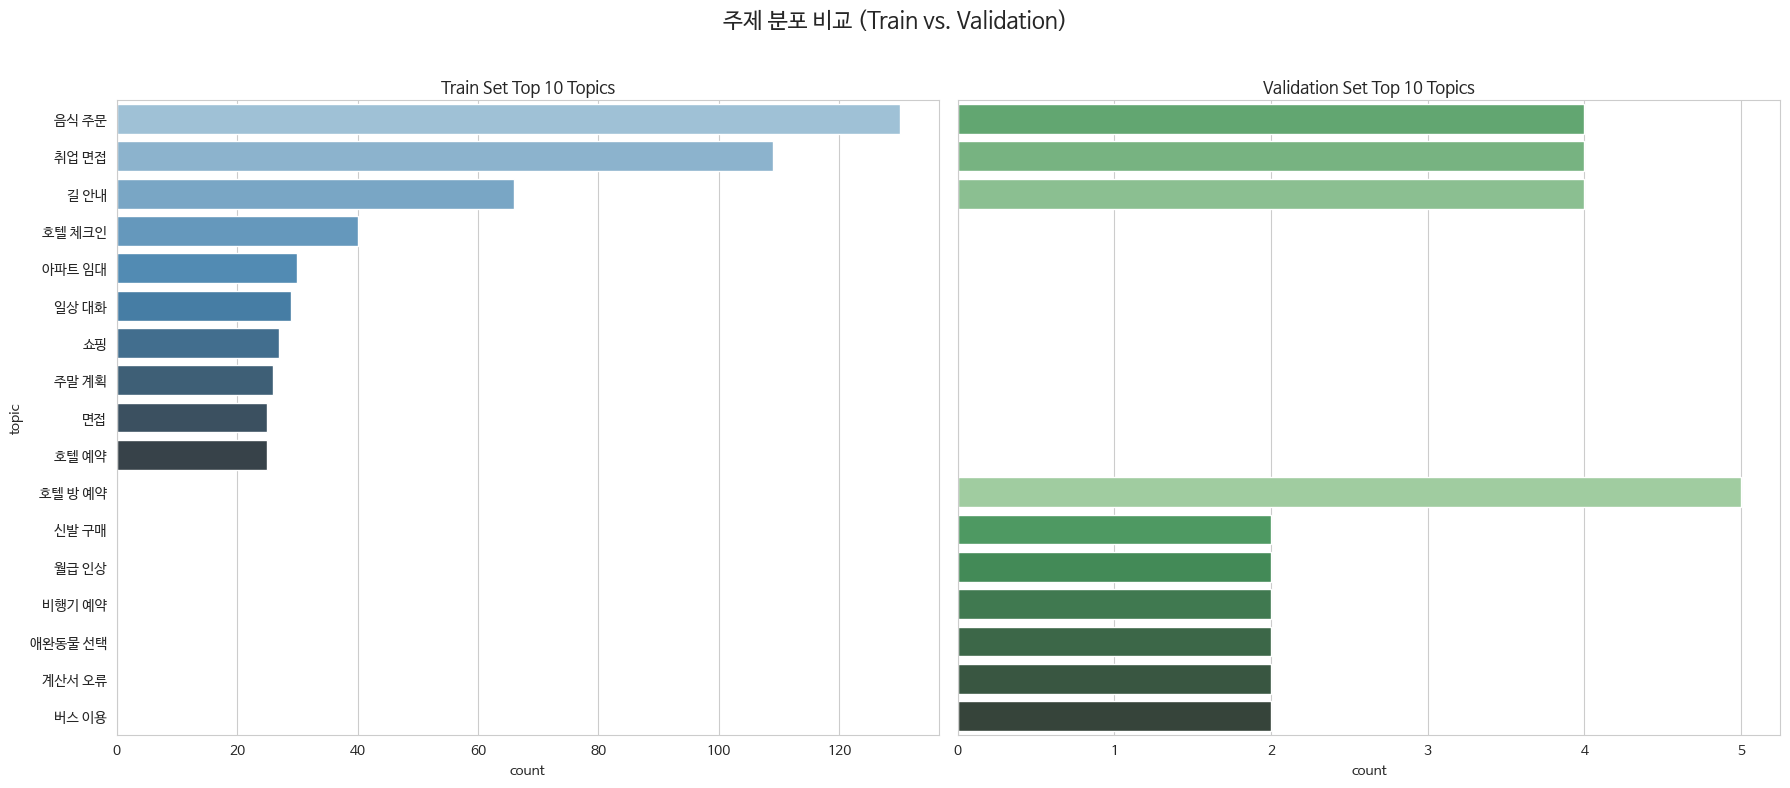

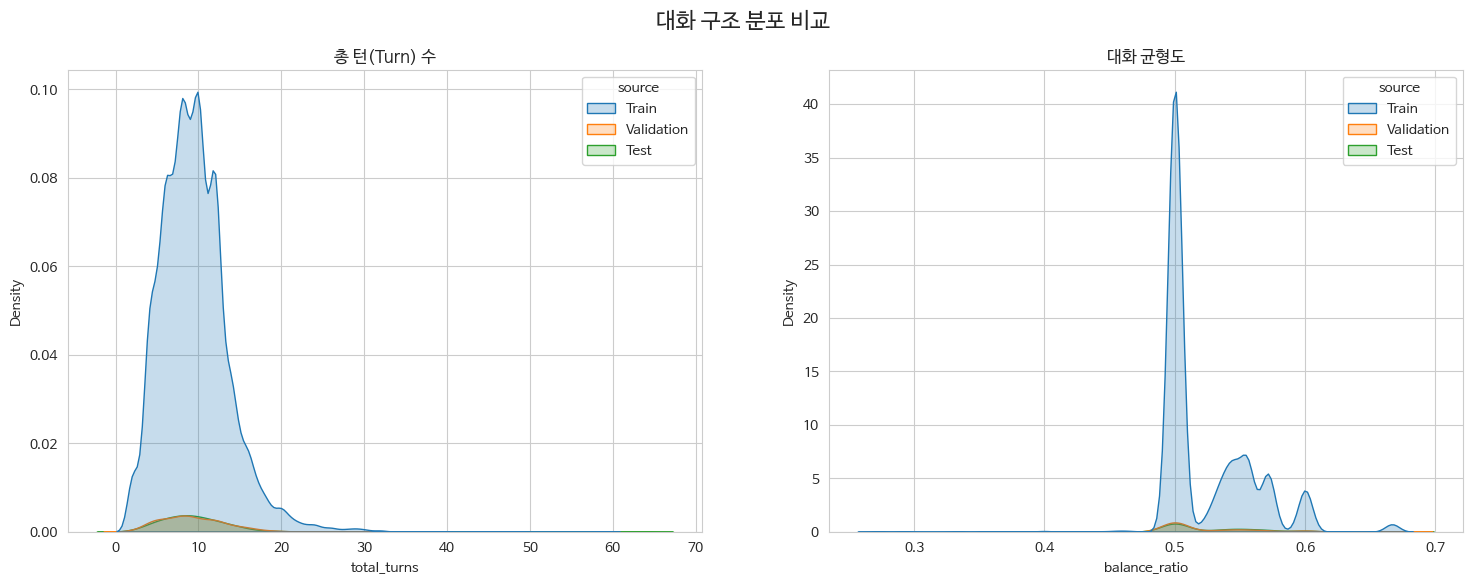

==================== 어휘 비교 분석 ====================
Train Set 고유 단어 수: 120,675 개
Validation Set 고유 단어 수: 13,695 개
Test Set 고유 단어 수: 14,244 개
--------------------------------------------------
Train 대비 Validation Set OOV 비율: 21.14%
Train 대비 Test Set OOV 비율: 23.60%


In [35]:
# 1. 데이터 로드 (기존 노트북 코드 활용)
data_path = '/home/data' # 실제 데이터 경로
train_df = pd.read_csv(f"{data_path}/train.csv")
val_df = pd.read_csv(f"{data_path}/dev.csv")
test_df = pd.read_csv(f"{data_path}/test.csv")

# 2. 위에서 정의한 비교 분석 함수 호출
compare_datasets(train_df, val_df, test_df)

In [36]:
# Ensure the necessary columns exist
if 'dialogue_word_count' not in train_df.columns:
    train_df['dialogue_word_count'] = train_df['dialogue'].apply(lambda x: len(str(x).split()))
if 'total_turns' not in train_df.columns:
    import re
    def analyze_dialogue_turns(dialogue):
        turns = re.split(r'(#Person\d#:\s*)', str(dialogue))
        if len(turns) <= 1:
            return 0
        # Count the number of tokens starting with "#Person"
        speakers = [t for t in turns if t.startswith('#Person')]
        return len(speakers)
    train_df['total_turns'] = train_df['dialogue'].apply(analyze_dialogue_turns)

# 가장 긴 대화문 3개 확인
print(" [가장 긴 대화문 Top 3] ".center(70, "="))
for i, row in train_df.nlargest(3, 'dialogue_word_count').iterrows():
    print(f"길이: {row['dialogue_word_count']} 단어")
    print(f"내용: {row['dialogue'][:]}") # 앞 200자만 출력
    print("-" * 70)

# 턴(Turn) 수가 가장 많은 대화 3개 확인
print("\n [턴(Turn) 수가 가장 많은 대화 Top 3] ".center(70, "="))
for i, row in train_df.nlargest(3, 'total_turns').iterrows():
    print(f"턴 수: {row['total_turns']} 턴")
    print(f"내용: {row['dialogue'][:]}")
    print("-" * 70)

========================== [가장 긴 대화문 Top 3] ==========================
길이: 508 단어
내용: #Person1#: 안녕, 어떻게 지내?
#Person2#: 음, 뭐 그냥 그럭저럭... 좀 그렇긴 해.
#Person1#: 그래, 엄마가 Daniel이 요즘 좀 안 좋다고 하더라. 무슨 일이야?
#Person2#: 음, 왜 그랬는지 모르겠는데, 아이들 키우는 게 이렇게 힘들 줄은 몰랐어.
#Person1#: 맞아, 그 마음 이해해. 무슨 문제가 있어?
#Person2#: 거의 6달 동안 애가 정말 우울해 보이고, 가끔 아침에 학교 가라고 깨우지도 못해. 너무 우울해 보이는데, 도대체 왜 그런지 모르겠어.
#Person1#: 6개월 동안 그런 거야?
#Person2#: 응, 주기적으로 그런 것 같아, 근데 어떻게 해야 할지 모르겠어. 그냥 스스로 괜찮아질 줄 알았어.
#Person1#: 아, 그게 좀 걱정이 많겠다. 나도 Jared이랑 안 어울리는 걸 좀 느꼈었는데. 그럼, 깨어 있을 땐 뭐해?
#Person2#: 음, 뭐, 대부분 깨어 있지 않아. 그냥 침대에 있기나 하고. [정말?] 아직도 이해가 안 가. 모르겠어.
#Person1#: 네, 그건 큰 문제야. 걔에 대해서 걱정할 만하구나. 심리 상담사나 심리학자, 누구한테라도 데려가 볼 생각했어?
#Person2#: 아, 아니. 그냥 일시적인 건가 싶어서. 학교에서 왕따를 당한다고 하긴 했는데, 이제 그런 얘기는 안 하더라고. 아마 끝난 것 같아.
#Person1#: 그러면 그때 왕따 같은 거 당했다는 거야?
#Person2#: 맞아, 그렇긴 해. 많이 얘기하진 않았어. 그냥 문제 좀 있었던 거라 생각했어.
#Person1#: 근데 그게 왕따 때문인지 아닌지는 모르겠고, 근데 이게 꽤 오랫동안 계속됐잖아. 진지하게 다뤄야 해.
#Person2#: 잘 모르겠어. 아, 그리고 여자친구가 최근에 헤어졌는데 아마 그게 그 아이에게 영향을 준 것 같아.
#Perso

## 3. Trainer 및 Trainingargs 구축하기
- Huggingface 의 Trainer 와 Training arguments를 활용하여 모델 학습을 일괄적으로 처리해주는 클래스를 정의합니다.

In [37]:
# 모델 성능에 대한 평가 지표를 정의합니다. 본 대회에서는 ROUGE 점수를 통해 모델의 성능을 평가합니다.
def compute_metrics(config,tokenizer,pred):
    rouge = Rouge()
    predictions = pred.predictions
    labels = pred.label_ids

    predictions[predictions == -100] = tokenizer.pad_token_id
    labels[labels == -100] = tokenizer.pad_token_id

    decoded_preds = tokenizer.batch_decode(predictions, clean_up_tokenization_spaces=True)
    labels = tokenizer.batch_decode(labels, clean_up_tokenization_spaces=True)

    # 정확한 평가를 위해 미리 정의된 불필요한 생성토큰들을 제거합니다.
    replaced_predictions = decoded_preds.copy()
    replaced_labels = labels.copy()
    remove_tokens = config['inference']['remove_tokens']
    for token in remove_tokens:
        replaced_predictions = [sentence.replace(token," ") for sentence in replaced_predictions]
        replaced_labels = [sentence.replace(token," ") for sentence in replaced_labels]

    print('-'*150)
    print(f"PRED: {replaced_predictions[0]}")
    print(f"GOLD: {replaced_labels[0]}")
    print('-'*150)
    print(f"PRED: {replaced_predictions[1]}")
    print(f"GOLD: {replaced_labels[1]}")
    print('-'*150)
    print(f"PRED: {replaced_predictions[2]}")
    print(f"GOLD: {replaced_labels[2]}")

    # 최종적인 ROUGE 점수를 계산합니다.
    results = rouge.get_scores(replaced_predictions, replaced_labels,avg=True)

    # ROUGE 점수 중 F-1 score를 통해 평가합니다.
    result = {key: value["f"] for key, value in results.items()}
    return result

In [ ]:
# 학습을 위한 trainer 클래스와 매개변수를 정의합니다.
def load_trainer_for_train(config,generate_model,tokenizer,train_inputs_dataset,val_inputs_dataset):
    print('-'*10, 'Make training arguments', '-'*10,)
    # set training args
    training_args = Seq2SeqTrainingArguments(
                output_dir=config['general']['output_dir'], # model output directory
                overwrite_output_dir=config['training']['overwrite_output_dir'],
                num_train_epochs=config['training']['num_train_epochs'],  # total number of training epochs
                learning_rate=config['training']['learning_rate'], # learning_rate
                per_device_train_batch_size=config['training']['per_device_train_batch_size'], # batch size per device during training
                per_device_eval_batch_size=config['training']['per_device_eval_batch_size'],# batch size for evaluation
                warmup_ratio=config['training']['warmup_ratio'],  # number of warmup steps for learning rate scheduler
                weight_decay=config['training']['weight_decay'],  # strength of weight decay
                lr_scheduler_type=config['training']['lr_scheduler_type'],
                optim =config['training']['optim'],
                gradient_accumulation_steps=config['training']['gradient_accumulation_steps'],
                eval_strategy=config['training']['eval_strategy'], # evaluation strategy to adopt during training
                save_strategy =config['training']['save_strategy'],
                save_total_limit=config['training']['save_total_limit'], # number of total save model.
                fp16=config['training']['fp16'],
                load_best_model_at_end=config['training']['load_best_model_at_end'], # 최종적으로 가장 높은 점수 저장
                seed=config['training']['seed'],
                logging_dir=config['training']['logging_dir'], # directory for storing logs
                logging_strategy=config['training']['logging_strategy'],
                predict_with_generate=config['training']['predict_with_generate'], #To use BLEU or ROUGE score
                #max_length=config['training']['max_length'],
                #min_length=config['training']['min_length'],
                do_train=config['training']['do_train'],
                do_eval=config['training']['do_eval'],
                report_to=config['training']['report_to'] # (선택) wandb를 사용할 때 설정합니다.
            )

    # (선택) 모델의 학습 과정을 추적하는 wandb를 사용하기 위해 초기화 해줍니다.
    wandb.init(
        #entity=config['wandb']['entity'],
        project=config['wandb']['project'],
        name=config['wandb']['name'],
    )

    # (선택) 모델 checkpoint를 wandb에 저장하도록 환경 변수를 설정합니다.
    os.environ["WANDB_LOG_MODEL"]="checkpoint"
    os.environ["WANDB_WATCH"]="false"

    # Validation loss가 더 이상 개선되지 않을 때 학습을 중단시키는 EarlyStopping 기능을 사용합니다.
    MyCallback = EarlyStoppingCallback(
        early_stopping_patience=config['training']['early_stopping_patience'],
        early_stopping_threshold=config['training']['early_stopping_threshold']
    )
    print('-'*10, 'Make training arguments complete', '-'*10,)
    print('-'*10, 'Make trainer', '-'*10,)

    # Trainer 클래스를 정의합니다.
    trainer = Seq2SeqTrainer(
        model=generate_model, # 사용자가 사전 학습하기 위해 사용할 모델을 입력합니다.
        args=training_args,
        train_dataset=train_inputs_dataset,
        eval_dataset=val_inputs_dataset,
        compute_metrics = lambda pred: compute_metrics(config,tokenizer, pred),
        callbacks = [MyCallback],

        ax_length=config['training']['max_length'], 
        min_length=config['training']['min_length'],
    )
    print('-'*10, 'Make trainer complete', '-'*10,)

    return trainer

In [39]:
# 학습을 위한 tokenizer와 사전 학습된 모델을 불러옵니다.
def load_tokenizer_and_model_for_train(config,device):
    print('-'*10, 'Load tokenizer & model', '-'*10,)
    print('-'*10, f'Model Name : {config["general"]["model_name"]}', '-'*10,)
    model_name = config['general']['model_name']
    bart_config = BartConfig().from_pretrained(model_name)
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    generate_model = BartForConditionalGeneration.from_pretrained(config['general']['model_name'],config=bart_config)

    special_tokens_dict={'additional_special_tokens':config['tokenizer']['special_tokens']}
    tokenizer.add_special_tokens(special_tokens_dict)

    generate_model.resize_token_embeddings(len(tokenizer)) # 사전에 special token을 추가했으므로 재구성 해줍니다.
    generate_model.to(device)

    generate_model.config.max_length = config['training']['max_length']
    generate_model.config.min_length = config['training']['min_length']

    print(generate_model.config)

    print('-'*10, 'Load tokenizer & model complete', '-'*10,)
    return generate_model , tokenizer

## 4. 모델 학습하기

- 앞에서 구축한 클래스 및 함수를 활용하여 학습 진행합니다.

In [40]:
def main(config):
    # 사용할 device를 정의합니다.
    device = torch.device('cuda:0' if torch.cuda.is_available()  else 'cpu')
    print('-'*10, f'device : {device}', '-'*10,)
    print(torch.__version__)

    # 사용할 모델과 tokenizer를 불러옵니다.
    generate_model , tokenizer = load_tokenizer_and_model_for_train(config,device)
    print('-'*10,"tokenizer special tokens : ",tokenizer.special_tokens_map,'-'*10)

    # 학습에 사용할 데이터셋을 불러옵니다.
    preprocessor = Preprocess(config['tokenizer']['bos_token'], config['tokenizer']['eos_token']) # decoder_start_token: str, eos_token: str
    data_path = config['general']['data_path']
    train_inputs_dataset, val_inputs_dataset = prepare_train_dataset(config,preprocessor, data_path, tokenizer)

    # Trainer 클래스를 불러옵니다.
    trainer = load_trainer_for_train(config, generate_model,tokenizer,train_inputs_dataset,val_inputs_dataset)
    trainer.train()   # 모델 학습을 시작합니다.

    # (선택) 모델 학습이 완료된 후 wandb를 종료합니다.
    wandb.finish()

In [41]:
if __name__ == "__main__":
    main(loaded_config)

---------- device : cuda:0 ----------
2.8.0+cu128
---------- Load tokenizer & model ----------
---------- Model Name : digit82/kobart-summarization ----------


You passed `num_labels=3` which is incompatible to the `id2label` map of length `2`.
The new embeddings will be initialized from a multivariate normal distribution that has old embeddings' mean and covariance. As described in this article: https://nlp.stanford.edu/~johnhew/vocab-expansion.html. To disable this, use `mean_resizing=False`


BartConfig {
  "activation_dropout": 0.0,
  "activation_function": "gelu",
  "add_bias_logits": false,
  "add_final_layer_norm": false,
  "architectures": [
    "BartForConditionalGeneration"
  ],
  "attention_dropout": 0.0,
  "bos_token_id": 0,
  "classif_dropout": 0.1,
  "classifier_dropout": 0.1,
  "d_model": 768,
  "decoder_attention_heads": 16,
  "decoder_ffn_dim": 3072,
  "decoder_layerdrop": 0.0,
  "decoder_layers": 6,
  "decoder_start_token_id": 2,
  "do_blenderbot_90_layernorm": false,
  "dropout": 0.1,
  "dtype": "float32",
  "encoder_attention_heads": 16,
  "encoder_ffn_dim": 3072,
  "encoder_layerdrop": 0.0,
  "encoder_layers": 6,
  "eos_token_id": 1,
  "extra_pos_embeddings": 2,
  "force_bos_token_to_be_generated": false,
  "forced_eos_token_id": 2,
  "id2label": {
    "0": "NEGATIVE",
    "1": "POSITIVE"
  },
  "init_std": 0.02,
  "is_encoder_decoder": true,
  "label2id": {
    "NEGATIVE": 0,
    "POSITIVE": 1
  },
  "max_length": 100,
  "max_position_embeddings": 1026,
 

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: leejunyeong1111 (4Tune). Use `wandb login --relogin` to force relogin


Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


---------- Make training arguments complete ----------
---------- Make trainer ----------
---------- Make trainer complete ----------


Epoch,Training Loss,Validation Loss,Rouge-1,Rouge-2,Rouge-l
1,5.554100,2.613810,0.180169,0.025531,0.175123
2,1.405500,0.716858,0.245142,0.045109,0.236703
3,0.625900,0.550761,0.340159,0.104506,0.317952
4,0.536400,0.535814,0.353419,0.123612,0.333683
5,0.500700,0.529715,0.358347,0.126325,0.338020
6,0.474500,0.525057,0.358613,0.129797,0.338154
7,0.451100,0.523035,0.363346,0.130775,0.343667
8,0.433700,0.524328,0.364585,0.131324,0.341487


/opt/conda/envs/nlp/lib/python3.10/site-packages/transformers/generation/utils.py:1733: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed in v5. Please use and modify the model generation configuration (see https://huggingface.co/docs/transformers/generation_strategies#default-text-generation-configuration )
  warnings.warn(


------------------------------------------------------------------------------------------------------------------------------------------------------
PRED:       는 천식 검사를 위해 폐 전문의에게 가보시는 것을 추천합니다.                                                                                
GOLD: #Person2# 는 숨쉬기 어려워합니다. 의사는 #Person2# 에게 증상을 확인하고, 천식 검사를 위해 폐 전문의에게 가볼 것을 권합니다.                                                                      
------------------------------------------------------------------------------------------------------------------------------------------------------
PRED:   농구하러 다리가 아파 아파하는 Jimmy를 위해   는  3시 30분에 체육관에서 운동하기로 했다.                                                                          
GOLD: #Person1# 는 Jimmy를 운동하러 초대하고 팔과 복근 운동을 하도록 설득합니다.                                                                                 
-------------------------------------------------------------------------------------------------------------------------------------------

/opt/conda/envs/nlp/lib/python3.10/site-packages/transformers/modeling_utils.py:3922: UserWarning: Moving the following attributes in the config to the generation config: {'max_length': 100}. You are seeing this warning because you've set generation parameters in the model config, as opposed to in the generation config.
  warnings.warn(
wandb: Adding directory to artifact (./checkpoint-250)... Done. 2.5s


------------------------------------------------------------------------------------------------------------------------------------------------------
PRED:    는   에게 감기에 걸렸는지 알립니다.   는 천식 검사를 위해 폐 전문의에게 가보라고 권합니다.                                                                     
GOLD: #Person2# 는 숨쉬기 어려워합니다. 의사는 #Person2# 에게 증상을 확인하고, 천식 검사를 위해 폐 전문의에게 가볼 것을 권합니다.                                                                      
------------------------------------------------------------------------------------------------------------------------------------------------------
PRED:    는   에게 농구 후 다리가 아파서 운동하자고 제안합니다.   는   에게 주 5일 동안 운동을 하자고 제안합니다.                                                                    
GOLD: #Person1# 는 Jimmy를 운동하러 초대하고 팔과 복근 운동을 하도록 설득합니다.                                                                                 
---------------------------------------------------------------------------------------------------------------------------------

wandb: Adding directory to artifact (./checkpoint-500)... Done. 2.0s


------------------------------------------------------------------------------------------------------------------------------------------------------
PRED:  #Person1# 은 감기에 걸렸습니다. #Person1# 은 천식 검사를 위해 폐 전문의에게 가보라고 권유합니다.                                                                            
GOLD: #Person2# 는 숨쉬기 어려워합니다. 의사는 #Person2# 에게 증상을 확인하고, 천식 검사를 위해 폐 전문의에게 가볼 것을 권합니다.                                                                      
------------------------------------------------------------------------------------------------------------------------------------------------------
PRED:  #Person1# 은 Jimmy에게 운동 날짜를 변경하자고 제안하고, Jimmy는 #Person2# 에게 금요일에 하기로 약속합니다.                                                                       
GOLD: #Person1# 는 Jimmy를 운동하러 초대하고 팔과 복근 운동을 하도록 설득합니다.                                                                                 
-------------------------------------------------------------------------------------------------------

wandb: Adding directory to artifact (./checkpoint-750)... Done. 2.0s


------------------------------------------------------------------------------------------------------------------------------------------------------
PRED:  #Person1# 은 감기에 걸리지 않았지만, #Person2# 는 천식 검사를 위해 폐 전문의에게 가보라고 권유합니다.                                                                           
GOLD: #Person2# 는 숨쉬기 어려워합니다. 의사는 #Person2# 에게 증상을 확인하고, 천식 검사를 위해 폐 전문의에게 가볼 것을 권합니다.                                                                      
------------------------------------------------------------------------------------------------------------------------------------------------------
PRED:  #Person1# 은 Jimmy에게 운동 날짜를 변경하자고 제안하지만, Jimmy는 토요일에 하기로 했습니다.                                                                           
GOLD: #Person1# 는 Jimmy를 운동하러 초대하고 팔과 복근 운동을 하도록 설득합니다.                                                                                 
--------------------------------------------------------------------------------------------------------------

wandb: Adding directory to artifact (./checkpoint-1000)... Done. 3.0s


------------------------------------------------------------------------------------------------------------------------------------------------------
PRED:  #Person1# 은 감기에 걸리지 않았지만, #Person2# 는 천식 검사를 위해 폐 전문의에게 가보라고 권합니다.                                                                           
GOLD: #Person2# 는 숨쉬기 어려워합니다. 의사는 #Person2# 에게 증상을 확인하고, 천식 검사를 위해 폐 전문의에게 가볼 것을 권합니다.                                                                      
------------------------------------------------------------------------------------------------------------------------------------------------------
PRED:  #Person1# 은 Jimmy에게 운동 날짜를 변경해 달라고 요청하고, Jimmy는 동의합니다.                                                                             
GOLD: #Person1# 는 Jimmy를 운동하러 초대하고 팔과 복근 운동을 하도록 설득합니다.                                                                                 
--------------------------------------------------------------------------------------------------------------------

wandb: Adding directory to artifact (./checkpoint-1250)... Done. 2.1s


------------------------------------------------------------------------------------------------------------------------------------------------------
PRED:  #Person1# 은 #Person2# 에게 감기에 걸리지 않았다고 말합니다. #Person2# 는 천식 검사를 위해 폐 전문의에게 가보라고 권합니다.                                                                      
GOLD: #Person2# 는 숨쉬기 어려워합니다. 의사는 #Person2# 에게 증상을 확인하고, 천식 검사를 위해 폐 전문의에게 가볼 것을 권합니다.                                                                      
------------------------------------------------------------------------------------------------------------------------------------------------------
PRED:  #Person1# 과 Jimmy는 운동 시간을 맞추기 위해 운동장에 가기로 했습니다. #Person2# 는 토요일에 운동하자고 제안했지만, Jimmy는 일요일에 하기로 했습니다.                                                              
GOLD: #Person1# 는 Jimmy를 운동하러 초대하고 팔과 복근 운동을 하도록 설득합니다.                                                                                 
-------------------------------------------------------------------------

wandb: Adding directory to artifact (./checkpoint-1500)... Done. 2.9s


------------------------------------------------------------------------------------------------------------------------------------------------------
PRED:  #Person1# 은 #Person2# 에게 감기와 천식 증상이 없다고 말합니다. #Person2# 는 천식 검사를 위해 폐 전문의에게 가보라고 권합니다.                                                                     
GOLD: #Person2# 는 숨쉬기 어려워합니다. 의사는 #Person2# 에게 증상을 확인하고, 천식 검사를 위해 폐 전문의에게 가볼 것을 권합니다.                                                                      
------------------------------------------------------------------------------------------------------------------------------------------------------
PRED:  #Person1# 과 Jimmy는 오늘 운동하기로 결정하고, #Person2# 는 토요일에 하기로 했습니다.                                                                               
GOLD: #Person1# 는 Jimmy를 운동하러 초대하고 팔과 복근 운동을 하도록 설득합니다.                                                                                 
----------------------------------------------------------------------------------------------

wandb: Adding directory to artifact (./checkpoint-1750)... Done. 2.2s


------------------------------------------------------------------------------------------------------------------------------------------------------
PRED:  #Person1# 은 #Person2# 에게 감기와 천식 관련 증상에 대해 묻습니다. #Person2# 는 천식 검사를 위해 폐 전문의에게 가보라고 권장합니다.                                                                  
GOLD: #Person2# 는 숨쉬기 어려워합니다. 의사는 #Person2# 에게 증상을 확인하고, 천식 검사를 위해 폐 전문의에게 가볼 것을 권합니다.                                                                      
------------------------------------------------------------------------------------------------------------------------------------------------------
PRED:  #Person1# 은 Jimmy에게 운동 날짜를 변경하자고 제안하고, Jimmy는 동의합니다.                                                                              
GOLD: #Person1# 는 Jimmy를 운동하러 초대하고 팔과 복근 운동을 하도록 설득합니다.                                                                                 
-------------------------------------------------------------------------------------------------------

wandb: Adding directory to artifact (./checkpoint-2000)... Done. 2.8s

Aborted!


KeyboardInterrupt: 

## 5. 모델 추론하기

In [42]:
# 이곳에 내가 사용할 wandb config 설정
loaded_config['inference']['ckt_path'] = "/home/code/checkpoint-1750"

- test data를 사용하여 모델의 성능을 확인합니다.

In [43]:
# tokenization 과정까지 진행된 최종적으로 모델에 입력될 데이터를 출력합니다.
def prepare_test_dataset(config,preprocessor, tokenizer):

    test_file_path = os.path.join(config['general']['data_path'],'test.csv')

    test_data = preprocessor.make_set_as_df(test_file_path,is_train=False)
    test_id = test_data['fname']

    print('-'*150)
    print(f'test_data:\n{test_data["dialogue"][0]}')
    print('-'*150)

    encoder_input_test , decoder_input_test = preprocessor.make_input(test_data,is_test=True)
    print('-'*10, 'Load data complete', '-'*10,)

    test_tokenized_encoder_inputs = tokenizer(encoder_input_test, return_tensors="pt", padding=True,
                    add_special_tokens=True, truncation=True, max_length=config['tokenizer']['encoder_max_len'], return_token_type_ids=False,)
    test_tokenized_decoder_inputs = tokenizer(decoder_input_test, return_tensors="pt", padding=True,
                    add_special_tokens=True, truncation=True, max_length=config['tokenizer']['decoder_max_len'], return_token_type_ids=False,)

    test_encoder_inputs_dataset = DatasetForInference(test_tokenized_encoder_inputs, test_id, len(encoder_input_test))
    print('-'*10, 'Make dataset complete', '-'*10,)

    return test_data, test_encoder_inputs_dataset

In [44]:
# 추론을 위한 tokenizer와 학습시킨 모델을 불러옵니다.
def load_tokenizer_and_model_for_test(config,device):
    print('-'*10, 'Load tokenizer & model', '-'*10,)

    model_name = config['general']['model_name']
    ckt_path = config['inference']['ckt_path']
    print('-'*10, f'Model Name : {model_name}', '-'*10,)
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    special_tokens_dict = {'additional_special_tokens': config['tokenizer']['special_tokens']}
    tokenizer.add_special_tokens(special_tokens_dict)

    generate_model = BartForConditionalGeneration.from_pretrained(ckt_path)
    generate_model.resize_token_embeddings(len(tokenizer))
    generate_model.to(device)
    print('-'*10, 'Load tokenizer & model complete', '-'*10,)

    return generate_model , tokenizer

In [45]:
# 수정된 inference 함수 전체 (이전에 수정된 load_trainer_for_train 및 config_data와 호환됨)
def inference(config):
    device = torch.device('cuda:0' if torch.cuda.is_available()  else 'cpu')
    print('-'*10, f'device : {device}', '-'*10,)
    print(torch.__version__)

    generate_model , tokenizer = load_tokenizer_and_model_for_test(config,device)

    data_path = config['general']['data_path']
    preprocessor = Preprocess(config['tokenizer']['bos_token'], config['tokenizer']['eos_token'])

    test_data, test_encoder_inputs_dataset = prepare_test_dataset(config,preprocessor, tokenizer)
    dataloader = DataLoader(test_encoder_inputs_dataset, batch_size=config['inference']['batch_size'])

    summary = []
    text_ids = []
    with torch.no_grad():
        for item in tqdm(dataloader):
            text_ids.extend(item['ID'])
            generated_ids = generate_model.generate(input_ids=item['input_ids'].to('cuda:0'),
                            no_repeat_ngram_size=config['inference']['no_repeat_ngram_size'],
                            early_stopping=config['inference']['early_stopping'],
                            max_length=config['inference']['max_length'],
                            min_length=config['inference']['min_length'], # ⭐ min_length로 인자 이름 수정
                            num_beams=config['inference']['num_beams'],
                        )
            for ids in generated_ids:
                result = tokenizer.decode(ids)
                summary.append(result)

    # 정확한 평가를 위하여 노이즈에 해당되는 스페셜 토큰을 제거합니다.
    remove_tokens = config['inference']['remove_tokens']
    preprocessed_summary = summary.copy()
    for token in remove_tokens:
        preprocessed_summary = [sentence.replace(token," ") for sentence in preprocessed_summary]

    output = pd.DataFrame(
        {
            "fname": test_data['fname'],
            "summary" : preprocessed_summary,
        }
    )
    result_path = config['inference']['result_path']
    if not os.path.exists(result_path):
        os.makedirs(result_path)
    output.to_csv(os.path.join(result_path, "output.csv"), index=False)

    return output

In [46]:
# 학습된 모델의 test를 진행합니다.
if __name__ == "__main__":
    output = inference(loaded_config)

---------- device : cuda:0 ----------
2.8.0+cu128
---------- Load tokenizer & model ----------
---------- Model Name : digit82/kobart-summarization ----------


You passed `num_labels=3` which is incompatible to the `id2label` map of length `2`.


---------- Load tokenizer & model complete ----------
------------------------------------------------------------------------------------------------------------------------------------------------------
test_data:
#Person1#: Ms. Dawson, 받아쓰기 좀 부탁드려야겠어요. 
#Person2#: 네, 말씀하세요... 
#Person1#: 이걸 오늘 오후까지 모든 직원들에게 사내 메모로 보내야 해요. 준비됐나요? 
#Person2#: 네, 말씀하세요. 
#Person1#: 모든 직원에게 알립니다... 즉시 발효되어 모든 사내 통신은 이메일과 공식 메모로만 제한됩니다. 근무 시간 동안 즉시 메시지 프로그램 사용은 금지됩니다. 
#Person2#: 이 정책이 사내 통신에만 적용되나요, 아니면 외부 통신에도 해당되나요? 
#Person1#: 이는 모든 통신에 적용됩니다. 사무실 내 직원 간 통신 뿐만 아니라 외부 통신도 해당됩니다. 
#Person2#: 하지만 많은 직원들이 고객과 소통하려고 즉시 메시지를 사용합니다. 
#Person1#: 통신 방법을 바꿔야 할 것입니다. 이 사무실에서는 즉시 메시지를 사용하는 것을 원하지 않습니다. 너무 많은 시간이 낭비됩니다! 이제 계속해서 메모를 작성해 주세요. 어디까지 했죠? 
#Person2#: 내외부 통신에 적용됩니다. 
#Person1#: 네. 즉시 메시지를 계속 사용하면 경고 후 시정 조치가 이루어지며, 두 번째 위반 시 해고될 수 있습니다. 이번 정책에 관한 질문은 부서장에게 문의하세요. 
#Person2#: 그게 다인가요? 
#Person1#: 네. 오늘 오후 4시까지 이 메모를 작성하고 배포해주세요.
----------------------------------------------------------------------------

100%|██████████| 16/16 [00:38<00:00,  2.41s/it]


In [47]:
output  # 각 대화문에 대한 요약문이 출력됨을 확인할 수 있습니다.

,fname,summary
0,test_0,#Person1# 은 Ms. Dawson에게 메시지를 사내 메모로 보내달라고 요청...
1,test_1,#Person1# 과 #Person2# 는 교통체증으로 인해 출퇴근에 어려움을 겪...
2,test_2,Kate는 Masha와 Hero가 이혼했다고 #Person1# 에게 말합니다. ...
3,test_3,#Person1# 은 Brian의 생일을 축하하기 위해 생일 파티에 초대합니다. ...
4,test_4,#Person1# 과 #Person2# 는 올림픽 공원의 크기와 시설에 대해 이야...
...,...,...
494,test_495,"Jack은 Charlie에게 새로운 비디오 게임을 제안하고, 게임에 대해 설명한..."
495,test_496,#Person1# 은 #Person2# 에게 시골 음악에 관심을 가지게 된 계기와...
496,test_497,#Person1# 은 Alice에게 세탁기에 비누가 들어 있지 않다고 설명합니다....
497,test_498,"Steve는 Matthew에게 임대를 갱신하고 싶지 않다고 말하며, Mrs. T..."


## 6. 모델 예측 분석
 - 모델의 예측을 분석해봅니다.

In [ ]:
from transformers import BartForConditionalGeneration, AutoTokenizer, Seq2SeqTrainingArguments, Seq2SeqTrainer

# 💡 [경로 지정] 가장 성능이 좋았던 체크포인트 폴더 경로를 입력하세요.
# 예: './checkpoint-1250' 또는 학습 완료 후 output_dir에 저장된 최종 모델 경로
# loaded_config['training']의 output_dir을 확인해보세요.
best_model_path = "./checkpoint-1750" # <--- 이 경로를 실제 체크포인트 경로로 수정해주세요.

print(f"'{best_model_path}' 경로에서 모델과 토크나이저를 불러옵니다...")

# 1. 모델과 토크나이저 로드
tokenizer = AutoTokenizer.from_pretrained("digit82/kobart-summarization")
model = BartForConditionalGeneration.from_pretrained(best_model_path)

# 2. TrainingArguments 다시 생성
#    평가만 수행할 것이므로, predict_with_generate=True 외에는 대부분 기본값이어도 괜찮습니다.
training_args = Seq2SeqTrainingArguments(
    output_dir='./eval_temp', # 임시 출력 폴더
    predict_with_generate=True,
    # 필요시 다른 인자들 추가 (per_device_eval_batch_size 등)
    per_device_eval_batch_size=16, 
)

# 3. 평가를 위한 Trainer 객체 새로 생성
trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    tokenizer=tokenizer,
    # compute_metrics는 predict() 시에는 호출되지 않으므로 필수는 아닙니다.
)

print("✅ 평가 준비가 완료되었습니다. 'trainer' 객체가 생성되었습니다.")

In [ ]:
import pandas as pd
import numpy as np
from rouge import Rouge

# val_df, val_inputs_dataset 변수는 이전에 생성되어 있어야 합니다.
# If val_inputs_dataset is not defined, create it using prepare_train_dataset
try:
    val_inputs_dataset
except NameError:
    print("val_inputs_dataset is not defined. Creating it now...")
    # Assuming that preprocessor, loaded_config, data_path, and tokenizer were defined earlier
    preprocessor = Preprocess(loaded_config['tokenizer']['bos_token'], loaded_config['tokenizer']['eos_token'])
    # prepare_train_dataset returns both train and validation datasets; get the second element for validation.
    _, val_inputs_dataset = prepare_train_dataset(loaded_config, preprocessor, data_path, tokenizer)

print("\n✅ Validation 데이터셋에 대한 요약 생성 및 개별 평가를 시작합니다...")

# 1. 예측 결과 생성
results = trainer.predict(val_inputs_dataset)
decoded_preds = tokenizer.batch_decode(results.predictions, skip_special_tokens=True)
label_ids = np.where(results.label_ids != -100, results.label_ids, tokenizer.pad_token_id)
decoded_labels = tokenizer.batch_decode(label_ids, skip_special_tokens=True)

eval_df = pd.DataFrame({
    '원본 대화문': val_df['dialogue'].tolist(),
    '정답 요약문': [label.strip() for label in decoded_labels],
    '모델이 생성한 요약문': [pred.strip() for pred in decoded_preds]
})

# 2. 각 샘플에 대한 ROUGE 점수 개별 계산
rouge = Rouge()
individual_scores = rouge.get_scores(eval_df['모델이 생성한 요약문'], eval_df['정답 요약문'], avg=False)
eval_df['ROUGE-L (F1)'] = [score['rouge-l']['f'] for score in individual_scores]

# 3. 상위/하위 5개 추출 및 출력
top_5_df = eval_df.sort_values(by='ROUGE-L (F1)', ascending=False).head(5)
bottom_5_df = eval_df.sort_values(by='ROUGE-L (F1)', ascending=True).head(5)

print("\n" + " [ ROUGE 점수 상위 5개 (Best 5) ] ".center(80, "🏆"))
for index, row in top_5_df.iterrows():
    print(f"\n--- Rank #{top_5_df.index.get_loc(index) + 1} (Score: {row['ROUGE-L (F1)']:.4f}) ---")
    print(f"📄 원본 대화: {row['원본 대화문'][:200]}...")
    print(f"✅ 정답 요약: {row['정답 요약문']}")
    print(f"🤖 모델 요약: {row['모델이 생성한 요약문']}")
print("=" * 80)

print("\n" + " [ ROUGE 점수 하위 5개 (Worst 5) ] ".center(80, "📉"))
for index, row in bottom_5_df.iterrows():
    print(f"\n--- Rank #{len(eval_df) - bottom_5_df.index.get_loc(index)} (Score: {row['ROUGE-L (F1)']:.4f}) ---")
    print(f"📄 원본 대화: {row['원본 대화문'][:200]}...")
    print(f"✅ 정답 요약: {row['정답 요약문']}")
    print(f"🤖 모델 요약: {row['모델이 생성한 요약문']}")
print("=" * 80)